<h1 style="margin-top:0;">Assignment 4: Major Project</h1>

**`Are Our Schools Safe? A Spatial Analysis of Flood Exposure and Socio-Economic Disadvantage in North Central Victoria`**

**Spatial Data Analytics (GEOM90006)**

**Semester 1, 2025**  
**Date:** 10 June, 2025  

**Group:** 3

___

**Table of contents**<a id='toc0_'></a>    
- [Introduction](#toc1_)    
- [Study Area and Datasets](#toc2_)    
  - [Polygon Data](#toc2_1_)    
    - [LGA Polygon Aligned to Topographic Features](#toc2_1_1_)    
      - [Study Area - North Central Victoria](#toc2_1_1_1_)    
    - [Victoria - 1 in 100 Year Flood Extent](#toc2_1_2_)    
    - [Statistical Area Level 2](#toc2_1_3_)    
  - [Point Data](#toc2_2_)    
    - [School Locations 2021](#toc2_2_1_)    
    - [Socio-Economic Indexes for SA2, AUS 2021](#toc2_2_2_)    
    - [2021 Census GCP for SA2, VIC 2021](#toc2_2_3_)    
  - [Raster Data](#toc2_3_)    
    - [VIC Elevation DEM 10m](#toc2_3_1_)    
      - [Pre-Processing](#toc2_3_1_1_)    
      - [Load DEM Raster](#toc2_3_1_2_)    
- [Exploratory Spatial Data Analysis](#toc3_)    
  - [Descriptive Statistics](#toc3_1_)    
    - [SEIFA IRSD Scores Distribution](#toc3_1_1_)    
    - [School Type Count at Each SAs](#toc3_1_2_)    
  - [Point Pattern Analysis](#toc3_2_)    
    - [School Distribution in LGAs](#toc3_2_1_)    
      - [Distance-based Methods](#toc3_2_1_1_)    
        - [Average Nearest Neighbour Analysis](#toc3_2_1_1_1_)    
        - [Ripley's K and L Functions](#toc3_2_1_1_2_)    
        - [Ripley's G and F Function](#toc3_2_1_1_3_)    
      - [Density-based methods](#toc3_2_1_2_)    
        - [Quadrat Count](#toc3_2_1_2_1_)    
        - [Kernel Density Estimation](#toc3_2_1_2_2_)    
  - [Areal Data Analysis](#toc3_3_)    
    - [Global Autocorrelation](#toc3_3_1_)    
      - [Moran’s 𝐼 Index, Geary’s 𝐶, General G-Statistic](#toc3_3_1_1_)    
    - [Local Autocorrelation](#toc3_3_2_)    
      - [Local Moran’s 𝐼 Index, Getis-Ord 𝐺𝑖 and 𝐺𝑖∗ statistics](#toc3_3_2_1_)    
  - [Raster Analysis](#toc3_4_)    
- [Geographically Weighted Regression](#toc4_)    
- [Discussion and Sustainability](#toc5_)    
- [Conclusion](#toc6_)    
- [References](#toc7_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

---

In [1]:
# Importing Required Packages

# --- General ---
import warnings
warnings.filterwarnings('ignore')

# --- System ---
import os
os.environ["USE_PYGEOS"] = "0"  # To ensure compatibility with Shapely

# --- Data Analysis ---
import numpy as np
import pandas as pd

from scipy.stats import skew , kurtosis
from scipy.stats import norm

# --- Geo ---
import geopandas as gpd
from geopandas import GeoDataFrame

from pysal.lib import weights

import pointpats
from pointpats import PointPattern
from pointpats import k_test, l_test
from pointpats import g_test, f_test
from pointpats import QStatistic

import rasterio
from rasterio.plot import show 
from rasterio.warp import reproject, Resampling, calculate_default_transform
from rasterio.mask import mask
from rasterio.enums import Resampling
from rasterio.transform import Affine

from shapely.geometry import mapping

import libpysal, esda
from esda.getisord import G

from esda.moran import Moran_Local
from esda.getisord import G_Local

from splot.esda import lisa_cluster

# --- Visualization ---
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import contextily as ctx
from matplotlib.lines import Line2D


___

# <a id='toc1_'></a>[Introduction](#toc0_)

**Research Question:** How does flood exposure and socio-economic disadvantage affect the spatial distribution and vulnerability of Government schools in North Central Victoria?

**Sub-questions:**
- Are Government schools disproportionately located in flood-prone zones compared to safer areas?
- Is there a spatial association between flood-exposed schools and low SEIFA (disadvantaged) areas?
- Are there discernible clustering patterns in school locations that indicate vulnerability hotspots?

___

# <a id='toc2_'></a>[Study Area and Datasets](#toc0_)

In [2]:
# Path to the data directory

## Point Data Paths

### School Locations 2021
slPath = 'Data/Point/School Locations 2021/dv309_schoollocations2021.csv'

### Socio-Economic Indexes for Areas (SEIFA), Australia
seifaPath = 'Data/Point/SEIFA Australia/SEIFA.xlsx'

### 2021 Census General Community Profile Statistical Area 2 for Victoria; G15 type of education institution attending (full-time/part-time student status by age) by sex
cenPath = 'Data/Point/2021 Census SA2/2021Census_G15_VIC_SA2.csv'

## Polygon Data Paths

### Vicmap Admin - Local Government Area Polygon Aligned to Topographic Features
lgaPath = 'Data/Polygon/LGA/Victoria/AD_LGA_AREA_POLYGON.shp'

### Victoria - 1 in 100 Year Flood Extent
floodPath = 'Data/Polygon/VIC Flood/extent_100y_ari.shp'

## Raster Data Paths

### Vicmap Elevation DEM 10m
if False:
    demPath = 'Data/Raster/Elevation/vmelev_dem10m_Geotiff_GDA94_Vicgrid.tif'

## <a id='toc2_1_'></a>[Polygon Data](#toc0_)

### <a id='toc2_1_1_'></a>[LGA Polygon Aligned to Topographic Features](#toc0_)

In [3]:
vicGDF = gpd.read_file(lgaPath).to_crs(epsg=7845)
vicGDF = vicGDF[vicGDF['STATE'] == "VIC"]

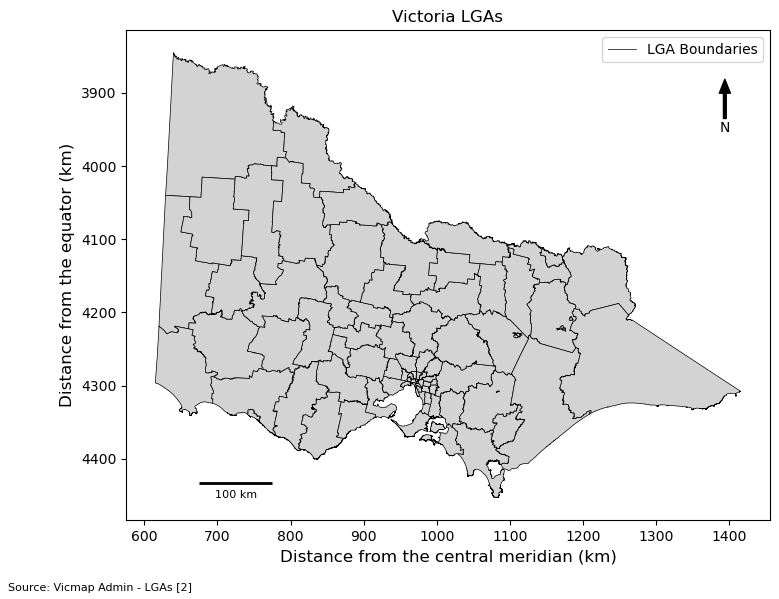

In [4]:
fig, ax = plt.subplots(figsize=(8, 6))

# Border
vicGDF.plot(ax=ax, edgecolor='black', facecolor='lightgrey', linewidth=0.5)

# Orientation
ax.annotate('N', xy=(0.93, 0.90), xytext=(0.93, 0.8),
            arrowprops=dict(facecolor='black', width=2, headwidth=8, headlength=10),
            ha='center', va='center', fontsize=10, xycoords='axes fraction')

# Legend
ax.plot([], [], '', label="LGA Boundaries", color='black', linewidth=0.5)
ax.legend(loc='upper right', fontsize=10)

# Title and Labels
ax.set_title("Victoria LGAs", fontsize=12)
ax.set_xlabel("Distance from the central meridian (km)", fontsize=12)
ax.set_ylabel("Distance from the equator (km)", fontsize=12)

# Scale Bar
sclX = ax.get_xlim()[0] + 100_000
sclY = ax.get_ylim()[0] + 50_000
ax.hlines(y=sclY, xmin=sclX, xmax=sclX + 100_000, colors='black', linewidth=2)
ax.text(s='100 km', x=sclX + 50_000, y=sclY - 20_000, ha='center', fontsize=8)

# Source
ax.annotate("Source: Vicmap Admin - LGAs [2]", 
            xy=(0.01, 0.01), xycoords='figure fraction', fontsize=8, ha='left', va='bottom')

ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{x / 1000:.0f}"))
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: f"{abs(y) / 1000:.0f}"))

plt.tight_layout()
plt.show()

#### <a id='toc2_1_1_1_'></a>[Study Area - North Central Victoria](#toc0_)

Mitchell, Campaspe, Greater Bendigo, Greater Sheppartorn, Strathbogie

In [5]:
targetLGA = ['MITCHELL', 'CAMPASPE', 'GREATER BENDIGO', 'GREATER SHEPPARTON', 'STRATHBOGIE']
lgaGDF = vicGDF[vicGDF["NAME"].isin(targetLGA)]
lgaGDF = lgaGDF.rename(columns={'OFFICIALNM': 'LGA Name'})

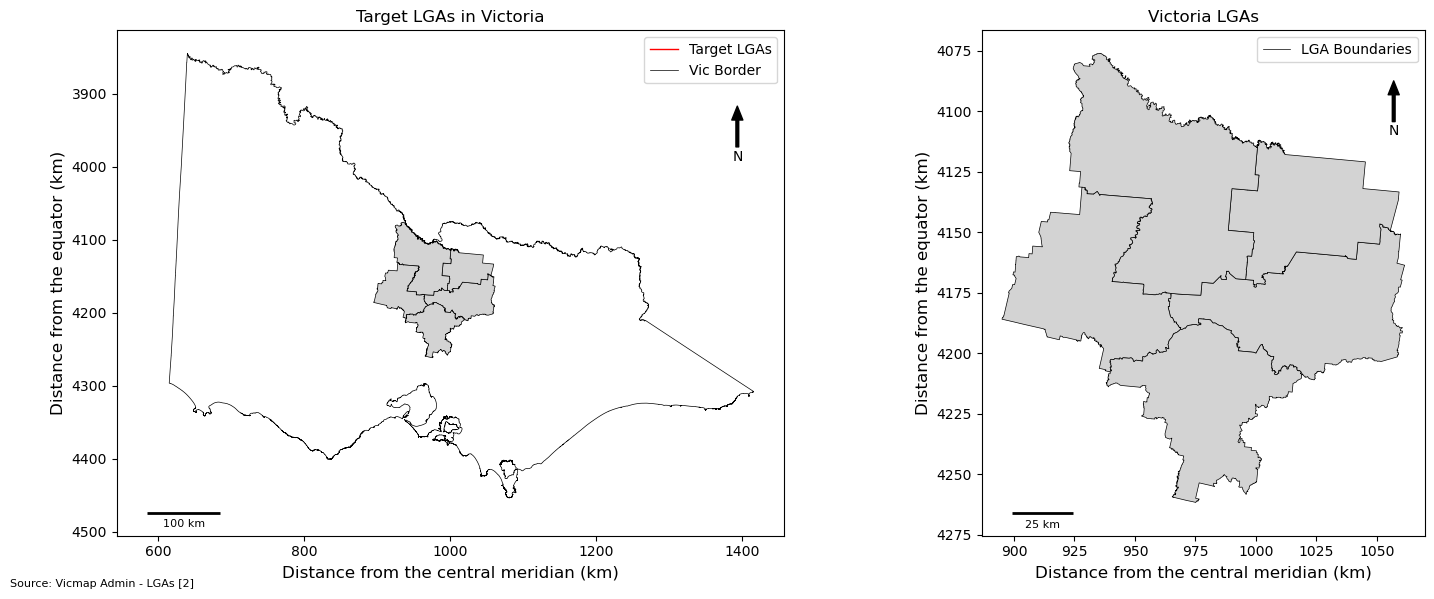

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

vicGDF.dissolve().boundary.plot(ax=ax1, edgecolor='black', linewidth=0.5)
lgaGDF.plot(ax=ax1, facecolor='lightgrey', edgecolor='black', linewidth=0.5)

# Orientation
ax1.annotate('N', xy=(0.93, 0.85), xytext=(0.93, 0.75),
             arrowprops=dict(facecolor='black', width=2, headwidth=8, headlength=10),
             ha='center', va='center', fontsize=10, xycoords='axes fraction')

# Legend
ax1.plot([], [], color='red', label="Target LGAs", linewidth=1)
ax1.plot([], [], color='black', label="Vic Border", linewidth=0.5)
ax1.legend(loc='upper right', fontsize=10)

# Title and labels
ax1.set_title("Target LGAs in Victoria", fontsize=12)
ax1.set_xlabel("Distance from the central meridian (km)", fontsize=12)
ax1.set_ylabel("Distance from the equator (km)", fontsize=12)

# Scale Bar
sclX1 = ax1.get_xlim()[0] + 10_000
sclY1 = ax1.get_ylim()[0] + 10_000
ax1.hlines(y=sclY1, xmin=sclX1, xmax=sclX1 + 100_000, colors='black', linewidth=2)
ax1.text(x=sclX1 + 50_000, y=sclY1 - 20_000, s='100 km', ha='center', fontsize=8)

# Axis formatting
ax1.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{x / 1000:.0f}"))
ax1.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: f"{abs(y) / 1000:.0f}"))

# Border
lgaGDF.plot(ax=ax2, edgecolor='black', facecolor='lightgrey', linewidth=0.5)

# Orientation
ax2.annotate('N', xy=(0.93, 0.90), xytext=(0.93, 0.8),
             arrowprops=dict(facecolor='black', width=2, headwidth=8, headlength=10),
             ha='center', va='center', fontsize=10, xycoords='axes fraction')

# Legend
ax2.plot([], [], '', label="LGA Boundaries", color='black', linewidth=0.5)
ax2.legend(loc='upper right', fontsize=10)

# Title and labels
ax2.set_title("Victoria LGAs", fontsize=12)
ax2.set_xlabel("Distance from the central meridian (km)", fontsize=12)
ax2.set_ylabel("Distance from the equator (km)", fontsize=12)

# Scale Bar
sclX = ax2.get_xlim()[0] + 12_500
sclY = ax2.get_ylim()[0] + 5_000
ax2.hlines(y=sclY, xmin=sclX, xmax=sclX + 25_000, colors='black', linewidth=2)
ax2.text(s='25 km', x=sclX + 12_500, y=sclY - 6_500, ha='center', fontsize=8)

# Source annotation
fig.text(0.01, 0.01, "Source: Vicmap Admin - LGAs [2]", fontsize=8, ha='left', va='bottom')

# Axis formatting
ax2.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{x / 1000:.0f}"))
ax2.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: f"{abs(y) / 1000:.0f}"))

plt.tight_layout()
plt.show()


### <a id='toc2_1_2_'></a>[Victoria - 1 in 100 Year Flood Extent](#toc0_)

In [7]:
if False:
    floodGDF = gpd.read_file(floodPath).to_crs(epsg=7845)

    floodGDF = gpd.clip(floodGDF, vicGDF.dissolve())

In [8]:
if False:
    floodGDF.to_file('Data/Polygon/VIC Flood/lgaFlood.gpkg', layer='flood', driver='GPKG')

In [9]:
floodGDF = gpd.read_file('Data/Polygon/VIC Flood/lgaFlood.gpkg', layer='flood')
floodLGA = gpd.clip(floodGDF, lgaGDF)

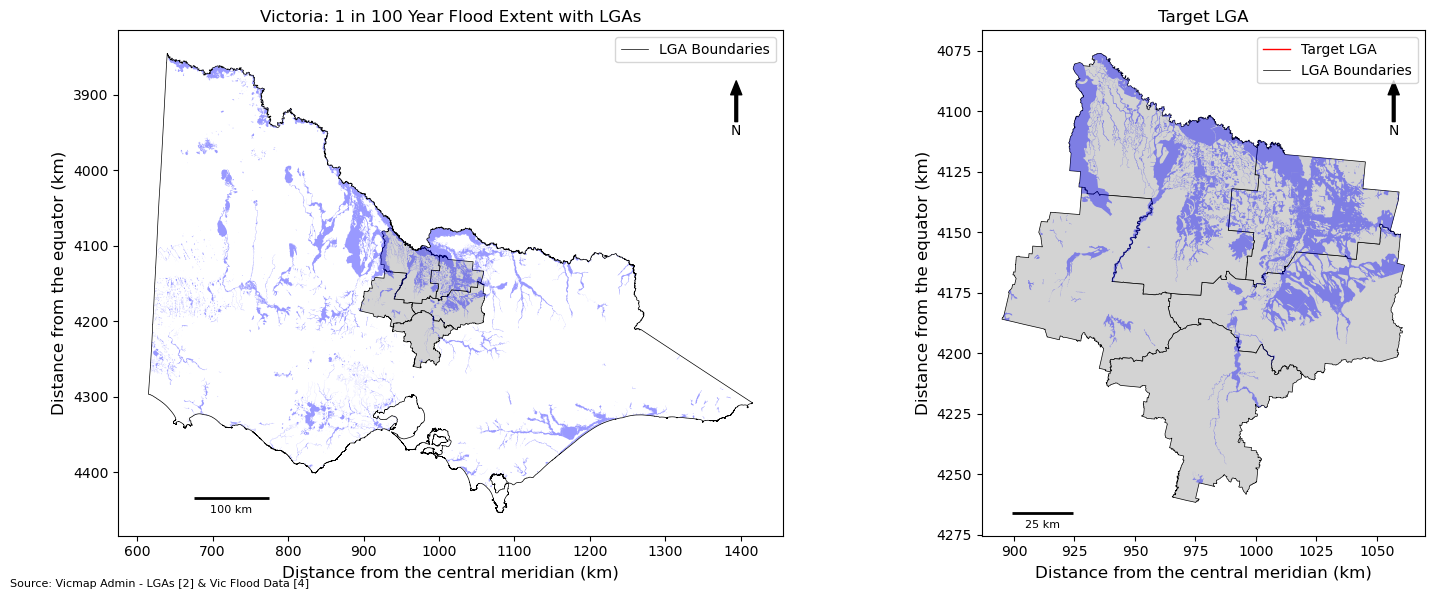

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

vicGDF.dissolve().boundary.plot(ax=ax1, edgecolor='black', linewidth=0.5)
lgaGDF.plot(ax=ax1, facecolor='lightgrey', edgecolor='black', linewidth=0.5)
floodGDF.plot(ax=ax1, color='blue', alpha=0.4, label='1 in 100 Year Flood Extent')

# Orientation
ax1.annotate('N', xy=(0.93, 0.90), xytext=(0.93, 0.8),
             arrowprops=dict(facecolor='black', width=2, headwidth=8, headlength=10),
             ha='center', va='center', fontsize=10, xycoords='axes fraction')

# Legend
ax1.plot([], [], '', label="LGA Boundaries", color='black', linewidth=0.5)
ax1.legend(loc='upper right', fontsize=10)

# Title and labels
ax1.set_title("Victoria: 1 in 100 Year Flood Extent with LGAs", fontsize=12)
ax1.set_xlabel("Distance from the central meridian (km)", fontsize=12)
ax1.set_ylabel("Distance from the equator (km)", fontsize=12)

# Scale bar
sclX1 = ax1.get_xlim()[0] + 100_000
sclY1 = ax1.get_ylim()[0] + 50_000
ax1.hlines(y=sclY1, xmin=sclX1, xmax=sclX1 + 100_000, colors='black', linewidth=2)
ax1.text(s='100 km', x=sclX1 + 50_000, y=sclY1 - 20_000, ha='center', fontsize=8)

# Axis formatting
ax1.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{x / 1000:.0f}"))
ax1.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: f"{abs(y) / 1000:.0f}"))


lgaGDF.plot(ax=ax2, facecolor='lightgrey', edgecolor='black', linewidth=0.5)
floodLGA.plot(ax=ax2, color='blue', alpha=0.4, label='1 in 100 Year Flood Extent')

# Orientation
ax2.annotate('N', xy=(0.93, 0.90), xytext=(0.93, 0.8),
             arrowprops=dict(facecolor='black', width=2, headwidth=8, headlength=10),
             ha='center', va='center', fontsize=10, xycoords='axes fraction')

# Legend
ax2.plot([], [], color='red', label="Target LGA", linewidth=1)
ax2.plot([], [], color='black', label="LGA Boundaries", linewidth=0.5)
ax2.legend(loc='upper right', fontsize=10)

# Title and labels
ax2.set_title("Target LGA", fontsize=12)
ax2.set_xlabel("Distance from the central meridian (km)", fontsize=12)
ax2.set_ylabel("Distance from the equator (km)", fontsize=12)

# Scale Bar
sclX2 = ax2.get_xlim()[0] + 12_500
sclY2 = ax2.get_ylim()[0] + 5_000
ax2.hlines(y=sclY2, xmin=sclX2, xmax=sclX2 + 25_000, colors='black', linewidth=2)
ax2.text(s='25 km', x=sclX2 + 12_500, y=sclY2 - 6_500, ha='center', fontsize=8)

# Axis formatting
ax2.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{x / 1000:.0f}"))
ax2.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: f"{abs(y) / 1000:.0f}"))

# Source annotation
fig.text(0.01, 0.01, "Source: Vicmap Admin - LGAs [2] & Vic Flood Data [4]", fontsize=8, ha='left', va='bottom')

plt.tight_layout()
plt.show()


### <a id='toc2_1_3_'></a>[Statistical Area Level 2](#toc0_)

In [11]:
sa2Path = 'Data/Polygon/SA2/SA2_2021_AUST_GDA2020.shp'
sa2GDF = gpd.read_file(sa2Path).to_crs(epsg=7845)

sa2GDF = sa2GDF[['SA2_CODE21', 'SA2_NAME21', 'AREASQKM21', 'STE_NAME21', 'geometry']].iloc[:-3, :].copy()
sa2GDF = sa2GDF.rename(columns={
    'SA2_CODE21': 'SA2 Code',
    'SA2_NAME21': 'SA2 Name',
    'AREASQKM21': 'Area',
    'STE_NAME21': 'State'
})
sa2GDF = sa2GDF[sa2GDF["State"] == "Victoria"].iloc[:-2, :]

sa2GDF['SA2 Code'] = sa2GDF['SA2 Code'].astype(int)

sa2GDF.head()

SA2 Code       SA2 Name      Area     State  \
644  201011001      Alfredton   52.7109  Victoria   
645  201011002       Ballarat   12.3787  Victoria   
646  201011005      Buninyong   51.5855  Victoria   
647  201011006      Delacombe   34.1607  Victoria   
648  201011007  Smythes Creek  104.7274  Victoria   

                                              geometry  
644  POLYGON ((867612.505 -4258484.096, 865228.817 ...  
645  POLYGON ((870905.748 -4257528.895, 870692.487 ...  
646  POLYGON ((872394.158 -4264374.277, 872398.991 ...  
647  POLYGON ((864539.767 -4260989.361, 864534.921 ...  
648  POLYGON ((862709.809 -4264443.168, 862696.336 ...

In [12]:
sa2 = {
    lgaName: gpd.clip(sa2GDF, lgaPoly)
    for lgaName, lgaPoly
    in lgaGDF.set_index('LGA Name').geometry.items()
}

sa2LGA = gpd.GeoDataFrame(
    pd.concat(
        [gdf.assign(**{'LGA Name': lga}) for lga, gdf in sa2.items()],
        ignore_index=True
    ),
    crs=sa2GDF.crs
)

sa2LGA.head()

SA2 Code          SA2 Name       Area     State  \
0  204011054         Alexandra  2118.9554  Victoria   
1  204011057  Mansfield (Vic.)  3927.8774  Victoria   
2  204011062               Yea  1474.2972  Victoria   
3  204011055             Euroa  2057.9046  Victoria   
4  204011058          Nagambie  1294.3498  Victoria   

                                            geometry           LGA Name  
0  MULTIPOLYGON (((1026991.773 -4207812.382, 1026...  STRATHBOGIE SHIRE  
1  MULTIPOLYGON (((1036457.832 -4202621.652, 1036...  STRATHBOGIE SHIRE  
2  MULTIPOLYGON (((1018345.888 -4208373.157, 1018...  STRATHBOGIE SHIRE  
3  POLYGON ((1013016.888 -4164093.610, 1013058.59...  STRATHBOGIE SHIRE  
4  POLYGON ((977288.001 -4175151.548, 977323.762 ...  STRATHBOGIE SHIRE

## <a id='toc2_2_'></a>[Point Data](#toc0_)

### <a id='toc2_2_1_'></a>[School Locations 2021](#toc0_)

In [13]:
slDF = pd.read_csv(slPath, encoding='windows-1252')

# Choosig only Government Primary and Secondary Schools
slDF = slDF[
    (slDF['Education_Sector'] == 'Government') & 
    ((slDF['School_Type'] == 'Primary') | (slDF['School_Type'] == 'Secondary')) &
    (slDF['Address_State'] == 'VIC')
][["School_Name", "School_Type", "Education_Sector", "LGA_Name", "X", "Y"]]

slDF.columns = ['School Name', 'School Type', 'Sector', 'LGA Name', 'Longitude', 'Latitude']

slDF.head()

School Name School Type      Sector  \
0                 Alberton Primary School     Primary  Government   
1  Allansford and District Primary School     Primary  Government   
2                    Avoca Primary School     Primary  Government   
3                   Avenel Primary School     Primary  Government   
4               Warrandyte Primary School     Primary  Government   

          LGA Name   Longitude   Latitude  
0   Wellington (S)  146.666601 -38.617713  
1  Warrnambool (C)  142.590393 -38.386281  
2     Pyrenees (S)  143.475649 -37.084502  
3  Strathbogie (S)  145.234722 -36.901368  
4   Manningham (C)  145.213980 -37.742675

In [14]:
slGDF = gpd.GeoDataFrame(
    slDF,
    geometry=gpd.points_from_xy(slDF.Longitude, slDF.Latitude),
    crs="EPSG:4326"                                          
).to_crs(epsg=7845)

In [15]:
slLGA = gpd.clip(slGDF, lgaGDF)
slLGA['inFlood'] = slLGA.buffer(250).intersects(floodLGA.unary_union)

We find if a school is exposed to flood in a 250m buffer zone at it's location and flag as true.

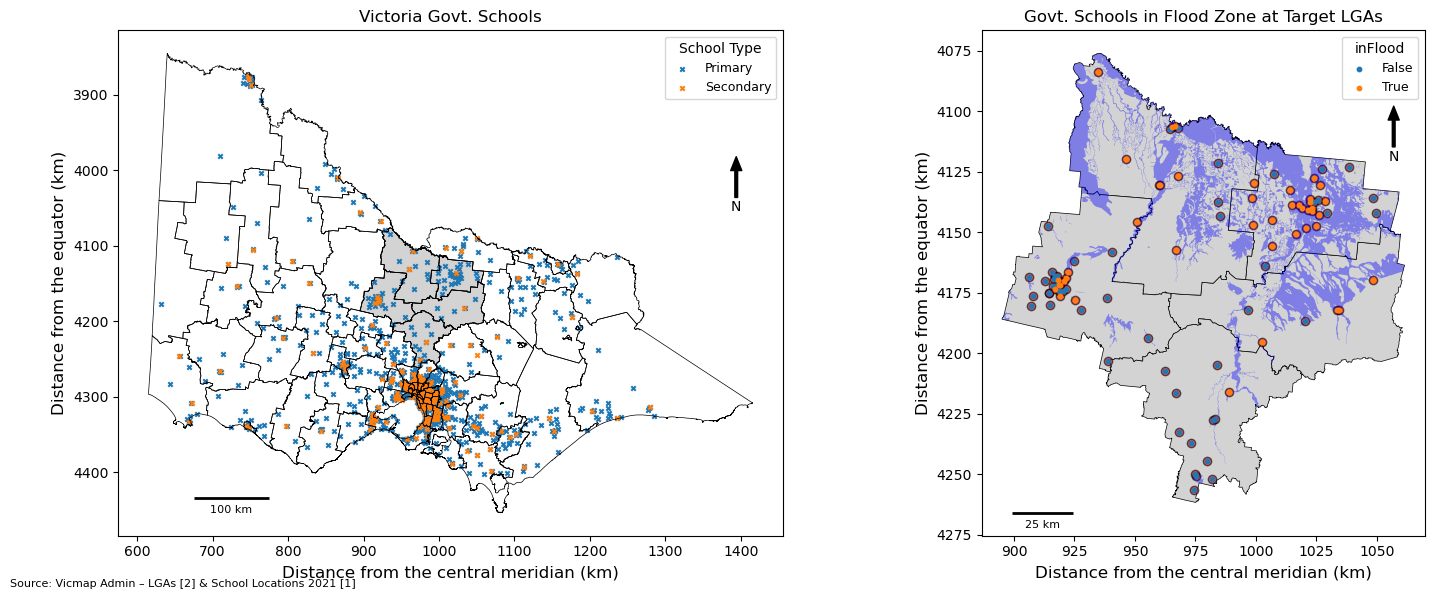

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Subplot 1
vicGDF.boundary.plot(ax=ax1, edgecolor='black', linewidth=0.5)
lgaGDF.plot(ax=ax1, facecolor='lightgrey', edgecolor='black', linewidth=0.5)

for type, group in slGDF.groupby('School Type'):
    group.plot(ax=ax1, marker='x', markersize=10, label=type, linestyle='None')

# Orientation
ax1.annotate('N', xy=(0.93, 0.75), xytext=(0.93, 0.65),
             arrowprops=dict(facecolor='black', width=2, headwidth=8, headlength=10),
             ha='center', va='center', fontsize=10, xycoords='axes fraction')

# Legend
ax1.legend(title="School Type", loc='upper right', fontsize=9, title_fontsize=10)

# Title and Labels
ax1.set_title("Victoria Govt. Schools", fontsize=12)
ax1.set_xlabel("Distance from the central meridian (km)", fontsize=12)
ax1.set_ylabel("Distance from the equator (km)", fontsize=12)

# Scale Bar
sclX1 = ax1.get_xlim()[0] + 100_000
sclY1 = ax1.get_ylim()[0] + 50_000
ax1.hlines(y=sclY1, xmin=sclX1, xmax=sclX1 + 100_000, colors='black', linewidth=2)
ax1.text(s='100 km', x=sclX1 + 50_000, y=sclY1 - 20_000, ha='center', fontsize=8)

# Axis Formatting
ax1.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{x / 1000:.0f}"))
ax1.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: f"{abs(y) / 1000:.0f}"))

# Subplot 2
lgaGDF.plot(ax=ax2, facecolor='lightgrey', edgecolor='black', linewidth=0.5)
slLGA.plot(ax=ax2, facecolor='red', edgecolor='black', linewidth=1, alpha=0.6)
floodLGA.plot(ax=ax2, color='blue', alpha=0.4, label='1 in 100 Year Flood Extent')

for type, group in slLGA.groupby('inFlood'):
    group.plot(ax=ax2, markersize=10, label=type, linestyle='None')

# Orientation
ax2.annotate('N', xy=(0.93, 0.85), xytext=(0.93, 0.75),
             arrowprops=dict(facecolor='black', width=2, headwidth=8, headlength=10),
             ha='center', va='center', fontsize=10, xycoords='axes fraction')

# Legend
ax2.legend(title="inFlood", loc='upper right', fontsize=9, title_fontsize=10)

# Title and Labels
ax2.set_title("Govt. Schools in Flood Zone at Target LGAs", fontsize=12)
ax2.set_xlabel("Distance from the central meridian (km)", fontsize=12)
ax2.set_ylabel("Distance from the equator (km)", fontsize=12)

# Scale Bar
sclX2 = ax2.get_xlim()[0] + 12_500
sclY2 = ax2.get_ylim()[0] + 5_000
ax2.hlines(y=sclY2, xmin=sclX2, xmax=sclX2 + 25_000, colors='black', linewidth=2)
ax2.text(s='25 km', x=sclX2 + 12_500, y=sclY2 - 6_500, ha='center', fontsize=8)

# Axis Formatting
ax2.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{x / 1000:.0f}"))
ax2.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: f"{abs(y) / 1000:.0f}"))

# Source Annotation
fig.text(0.01, 0.01, "Source: Vicmap Admin – LGAs [2] & School Locations 2021 [1]", 
         fontsize=8, ha='left', va='bottom')

plt.tight_layout()
plt.show()


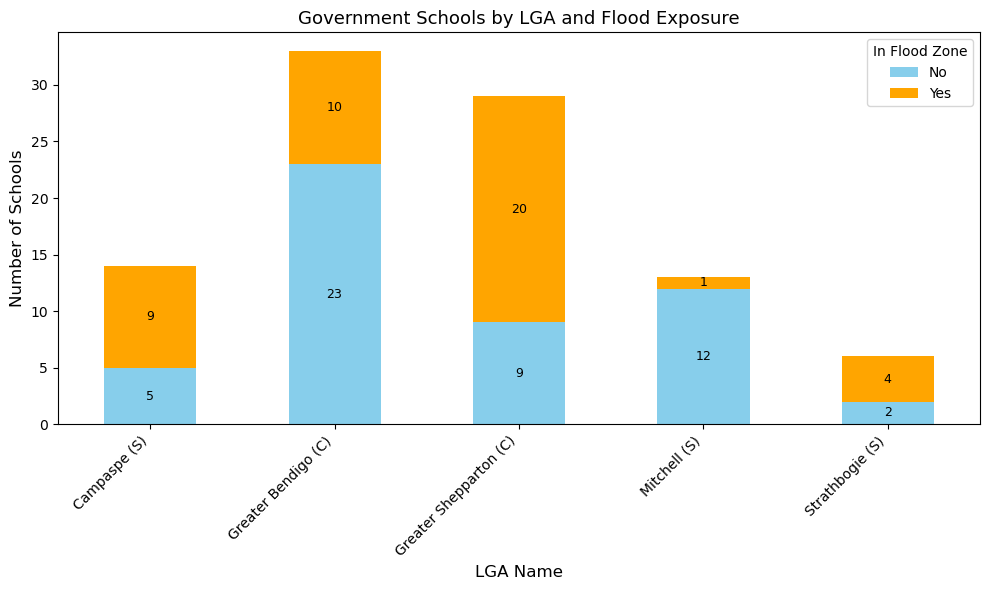

In [17]:
ax = (slLGA.groupby(['LGA Name', 'inFlood'])
           .size()
           .unstack(fill_value=0)
           .plot(kind='bar', stacked=True, figsize=(10, 6), color=['skyblue', 'orange']))

plt.title("Government Schools by LGA and Flood Exposure", fontsize=13)
plt.xlabel("LGA Name", fontsize=12)
plt.ylabel("Number of Schools", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title="In Flood Zone", labels=["No", "Yes"])
plt.tight_layout()

for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width() / 2,
                    bar.get_y() + height / 2,
                    f"{int(height)}",
                    ha='center', va='center', fontsize=9, color='black')

plt.show()


### <a id='toc2_2_2_'></a>[Socio-Economic Indexes for SA2, AUS 2021](#toc0_)

In [18]:
seifaDF = pd.read_excel(seifaPath, sheet_name="Table 1", skiprows=5)

seifaDF = seifaDF.iloc[:-2, :3]
seifaDF.columns = ['SA2 Code', 'SA2 Name', 'Score']

seifaDF['SA2 Code'] = seifaDF['SA2 Code'].astype(int)

seifaDF.head()

SA2 Code                         SA2 Name Score
0  101021007                        Braidwood  1024
1  101021008                          Karabar   994
2  101021009                       Queanbeyan  1010
3  101021010                Queanbeyan - East  1025
4  101021012  Queanbeyan West - Jerrabomberra  1098

In [19]:
merged = sa2GDF.merge(seifaDF, on=['SA2 Code', 'SA2 Name'], how='left')
seifaSA2 = gpd.GeoDataFrame(merged, geometry='geometry', crs=sa2GDF.crs)

sa2Lga = {
    lga: gpd.clip(seifaSA2, lgaGeom)
    for lga, lgaGeom in lgaGDF.set_index("LGA Name").geometry.items()
}

seifaLGA = gpd.GeoDataFrame(
    pd.concat([gdf.assign(**{'LGA Name': lga}) for lga, gdf in sa2Lga.items()],
              ignore_index=True),
    crs=seifaSA2.crs
)

seifaLGA['Score'] = pd.to_numeric(seifaLGA['Score'], errors='coerce')

### <a id='toc2_2_3_'></a>[2021 Census GCP for SA2, VIC 2021](#toc0_)

In [20]:
cenDF = pd.read_csv(cenPath)
cenDF = cenDF[["SA2_CODE_2021", "Primary_Government_P", "Secondary_Government_P"]]
cenDF.columns = ["SA2 Code", "Primary Government Students", "Secondary Government Students"]

cenDF['SA2 Code'] = cenDF['SA2 Code'].astype(int)

cenDF.head()

SA2 Code  Primary Government Students  Secondary Government Students
0  201011001                          973                            799
1  201011002                          333                            180
2  201011005                          457                            175
3  201011006                          593                            426
4  201011007                          287                            179

In [21]:
merged = sa2GDF.merge(cenDF, on='SA2 Code', how='left')
cenSA2 = gpd.GeoDataFrame(merged, geometry='geometry', crs=sa2GDF.crs)

cenLga = {
    lga: gpd.clip(cenSA2, lgaGeom)
    for lga, lgaGeom in lgaGDF.set_index("LGA Name").geometry.items()
}

cenLGA = gpd.GeoDataFrame(
    pd.concat([gdf.assign(**{'LGA Name': lga}) for lga, gdf in cenLga.items()],
              ignore_index=True),
    crs=cenSA2.crs
)

cenLGA.head()

SA2 Code          SA2 Name       Area     State  \
0  204011054         Alexandra  2118.9554  Victoria   
1  204011057  Mansfield (Vic.)  3927.8774  Victoria   
2  204011062               Yea  1474.2972  Victoria   
3  204011055             Euroa  2057.9046  Victoria   
4  204011058          Nagambie  1294.3498  Victoria   

                                            geometry  \
0  MULTIPOLYGON (((1026991.773 -4207812.382, 1026...   
1  MULTIPOLYGON (((1036457.832 -4202621.652, 1036...   
2  MULTIPOLYGON (((1018345.888 -4208373.157, 1018...   
3  POLYGON ((1013016.888 -4164093.610, 1013058.59...   
4  POLYGON ((977288.001 -4175151.548, 977323.762 ...   

   Primary Government Students  Secondary Government Students  \
0                          242                            289   
1                          501                            403   
2                          164                            147   
3                          213                            220   
4                          238                            130   

            LGA Name  
0  STRATHBOGIE SHIRE  
1  STRATHBOGIE SHIRE  
2  STRATHBOGIE SHIRE  
3  STRATHBOGIE SHIRE  
4  STRATHBOGIE SHIRE

## <a id='toc2_3_'></a>[Raster Data](#toc0_)

### <a id='toc2_3_1_'></a>[VIC Elevation DEM 10m](#toc0_)

#### <a id='toc2_3_1_1_'></a>[Pre-Processing](#toc0_)

In [22]:
if False:
    dem = rasterio.open(demPath, 'r')

In [23]:
if False:
    print(f'Original CRS: {dem.crs}')

    dstCRS = 'EPSG:7845'
    dstTransform, dstWidth, dstHeight = calculate_default_transform(
        dem.crs, dstCRS,
        dem.width, dem.height,
        *dem.bounds
    )

    dstArr = np.empty((dstHeight, dstWidth), dtype=dem.dtypes[0])

    reproject(
        source      = dem.read(1),
        destination = dstArr,
        src_transform = dem.transform,
        src_crs     = dem.crs,
        dst_transform = dstTransform,
        dst_crs     = dstCRS,
        resampling  = Resampling.bilinear,
        src_nodata  = dem.nodata,
        dst_nodata  = dem.nodata
    )

    print(f'Reprojected array shape: {dstArr.shape}')
    print(f'Transformed CRS: {dstCRS}')

In [24]:
if False:    
    geometry = [mapping(lgaGDF.unary_union)]

    with rasterio.open(
        'projDEM.tif', 'w',
        driver='GTiff',
        height=dstArr.shape[0],
        width=dstArr.shape[1],
        count=1,
        dtype=dstArr.dtype,
        crs=dstCRS,
        transform=dstTransform,
        nodata=dem.nodata
    ) as dst:
        dst.write(dstArr, 1)

    with rasterio.open('projDEM.tif') as src:
        clipArr, clippedTransform = mask(src, geometry, crop=True)
        clipMeta = src.meta.copy()
        clipMeta.update({
            'height': clipArr.shape[1],
            'width': clipArr.shape[2],
            'transform': clippedTransform
        })

    with rasterio.open('clippedDEM.tif', 'w', **clipMeta) as dst:
        dst.write(clipArr)

In [25]:
if False:
    def downsample(arr, transform, factor):
        outH = arr.shape[1] // factor
        outW = arr.shape[2] // factor

        outTransform = transform * Affine.scale(factor)

        outArr = np.empty((1, outH, outW), dtype=arr.dtype)

        reproject(
            source         = arr,
            destination    = outArr,
            src_transform  = transform,
            src_crs        = dstCRS,
            dst_transform  = outTransform,
            dst_crs        = dstCRS,
            resampling     = Resampling.bilinear,
            src_nodata     = dem.nodata,
            dst_nodata     = dem.nodata
        )
        return outArr, outTransform


    downsampledArr, downsampledTransform = downsample(clipArr, clippedTransform, factor=10)
    downsampledMeta = clipMeta.copy()
    downsampledMeta.update({
        'height': downsampledArr.shape[1],
        'width': downsampledArr.shape[2],
        'transform': downsampledTransform
    })

In [26]:
if False:
    outputPath = os.path.join("Data/Raster/Elevation", "lgaDEM100m.tif")

    with rasterio.open(outputPath, 'w', **downsampledMeta) as dst:
        dst.write(downsampledArr)

#### <a id='toc2_3_1_2_'></a>[Load DEM Raster](#toc0_)

In [27]:
rasterPath = 'Data/Raster/Elevation/lgaDEM100m.tif'

with rasterio.open(rasterPath) as src:
    dsArr = src.read(1)
    dsTransform = src.transform
    dsCRS = src.crs
    dsBounds = src.bounds
    dsMeta = src.meta
    nodata = src.nodata

print(f"Shape: {dsArr.shape}")
print(f"CRS: {dsCRS}")
print(f"Bounds: {dsBounds}")
print(f"Transform:\n{dsTransform}")

Shape: (1852, 1660)
CRS: EPSG:7845
Bounds: BoundingBox(left=895054.7992178279, bottom=-4261580.7652899735, right=1061327.350064092, top=-4076076.690490406)
Transform:
| 100.16, 0.00, 895054.80|
| 0.00,-100.16,-4076076.69|
| 0.00, 0.00, 1.00|


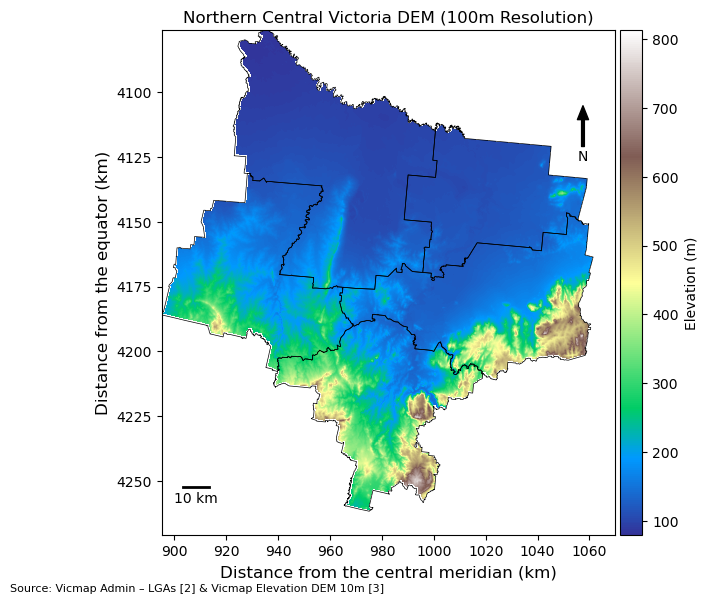

In [28]:
dsArr = np.where(dsArr == nodata, np.nan, dsArr)

fig, ax = plt.subplots(figsize=(8, 6))

# DEM background
im = rasterio.plot.show(
    dsArr,
    ax=ax,
    transform=dsTransform,
    cmap='terrain',
    interpolation='bilinear'
)
im = im.get_images()[0]

# Overlay LGA boundary
lgaGDF.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=0.5)

# Orientation (North arrow)
ax.annotate(
    'N',
    xy=(0.93, 0.85), xytext=(0.93, 0.75),
    xycoords='axes fraction',
    textcoords='axes fraction',
    arrowprops=dict(facecolor='black', width=2, headwidth=8, headlength=10),
    ha='center',
    va='center',
    fontsize=10
)

# Legend
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical').set_label('Elevation (m)')

# Scale bar
minX = dsTransform.c
maxY = dsTransform.f
maxX = minX + dsTransform.a * dsArr.shape[1]
minY = maxY + dsTransform.e * dsArr.shape[0]

sbLength = 10000  # metres
sbX = minX + (maxX - minX) * 0.05
sbY = minY + (maxY - minY) * 0.05
ax.plot([sbX, sbX + sbLength], [sbY, sbY], color='black', linewidth=2)
ax.text(
    sbX + sbLength / 2,
    sbY - (maxY - minY) * 0.01,
    '10 km',
    ha='center',
    va='top',
    fontsize=10
)

# Title and labels
ax.set_title('Northern Central Victoria DEM (100m Resolution)', fontsize=12)
ax.set_xlabel('Distance from the central meridian (km)', fontsize=12)
ax.set_ylabel('Distance from the equator (km)', fontsize=12)

# Axis formatting
ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{x / 1000:.0f}"))
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: f"{abs(y) / 1000:.0f}"))
ax.set_aspect('equal')

# Source annotation
fig.text(0.01, 0.001, "Source: Vicmap Admin – LGAs [2] & Vicmap Elevation DEM 10m [3]", 
         fontsize=8, ha='left', va='bottom')

plt.tight_layout()
plt.show()


___

# <a id='toc3_'></a>[Exploratory Spatial Data Analysis](#toc0_)

## <a id='toc3_1_'></a>[Descriptive Statistics](#toc0_)

### <a id='toc3_1_1_'></a>[SEIFA IRSD Scores Distribution](#toc0_)

In [29]:
grouped = seifaLGA.groupby('LGA Name')['Score']

summary = grouped.agg([
    ('Mean', 'mean'),
    ('Median', 'median'),
    ('Minimum', 'min'),
    ('Maximum', 'max'),
    ('Standard Deviation', 'std'),
    ('Skewness', lambda x: skew(x)),
    ('Kurtosis', lambda x: kurtosis(x))
]).round(2)

display(summary)

Mean  Median  Minimum  Maximum  \
LGA Name                                                     
CAMPASPE SHIRE            968.92   968.5      941      998   
GREATER BENDIGO CITY      991.28   994.0      912     1079   
GREATER SHEPPARTON CITY   969.23   975.0      854     1042   
MITCHELL SHIRE           1004.86  1009.5      902     1047   
STRATHBOGIE SHIRE         996.36   989.0      941     1046   

                         Standard Deviation  Skewness  Kurtosis  
LGA Name                                                         
CAMPASPE SHIRE                        18.40      0.11     -0.97  
GREATER BENDIGO CITY                  51.05      0.27     -0.90  
GREATER SHEPPARTON CITY               52.85     -0.73      0.12  
MITCHELL SHIRE                        39.21     -1.24      1.34  
STRATHBOGIE SHIRE                     32.34      0.01     -0.97

<Figure size 1000x500 with 0 Axes>

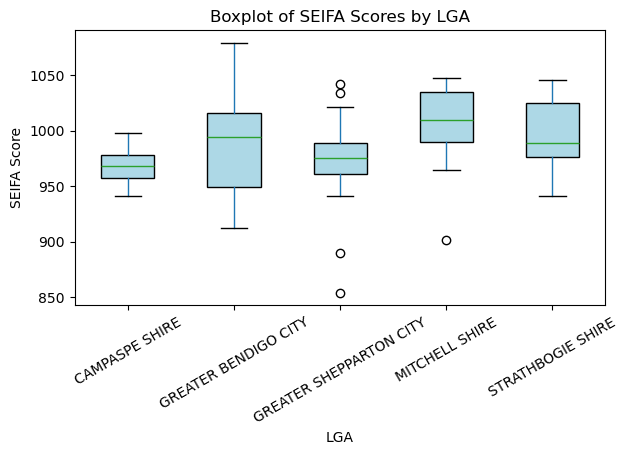

In [30]:
plt.figure(figsize=(10, 5))
seifaLGA.boxplot(column='Score', by='LGA Name', grid=False, patch_artist=True, boxprops=dict(facecolor="lightblue"))
plt.title('Boxplot of SEIFA Scores by LGA')
plt.suptitle('')
plt.xlabel('LGA')
plt.ylabel('SEIFA Score')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

### <a id='toc3_1_2_'></a>[School Type Count at Each SAs](#toc0_)

In [31]:
pivot = (slLGA.groupby(['LGA Name','School Type'])
                   .size()
                   .unstack(fill_value=0)
                   .assign(Total=lambda d: d.sum(1))
                   .sort_values('Total',ascending=False))

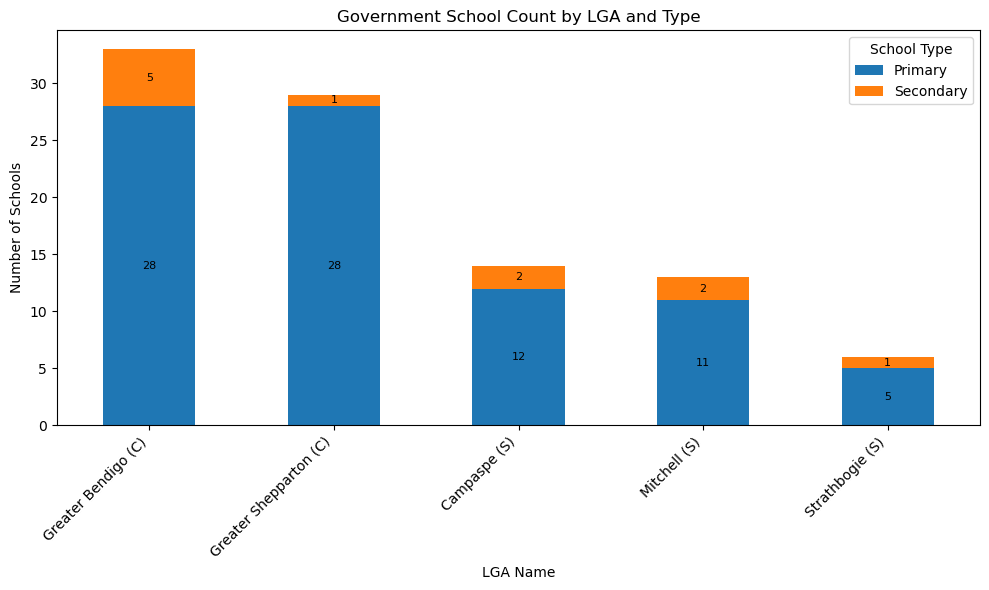

In [32]:
ax = pivot[['Primary', 'Secondary']].plot(kind='bar', stacked=True, figsize=(10, 6))

plt.title('Government School Count by LGA and Type')
plt.xlabel('LGA Name')
plt.ylabel('Number of Schools')
plt.xticks(rotation=45, ha='right')
plt.legend(title='School Type')
plt.tight_layout()

for c in ax.containers:
    ax.bar_label(c, label_type='center', fontsize=8, color='black')

plt.show()


## <a id='toc3_2_'></a>[Point Pattern Analysis](#toc0_)

### <a id='toc3_2_1_'></a>[School Distribution in LGAs](#toc0_)

#### <a id='toc3_2_1_1_'></a>[Distance-based Methods](#toc0_)

##### <a id='toc3_2_1_1_1_'></a>[Average Nearest Neighbour Analysis](#toc0_)

In [33]:
rows = []

for lgaName, lgaPoly in lgaGDF.set_index("LGA Name").geometry.items():

    schoolsInLGA = slLGA[slLGA.within(lgaPoly)]

    coords = [(g.x, g.y) for g in schoolsInLGA.geometry]
    pp = PointPattern(np.array(coords))

    obs = pp.mean_nnd
    n   = pp.n
    dens = n / lgaPoly.area

    exp = 0.5 / np.sqrt(dens)
    sd  = 0.26136 / np.sqrt(dens)
    zVal = (obs - exp) / sd
    pVal = 2 * (1 - norm.cdf(abs(zVal)))

    Rval = obs / exp
    patt = 'clustered' if Rval < 1 else 'dispersed' if Rval > 1 else 'random'

    rows.append({
        'LGA Name': lgaName,
        'Schools': n,
        'Obs Mean NND (m)': round(obs, 2),
        'Exp Mean NND (m)': round(exp, 2),
        'R': round(Rval, 2),
        'Z-score': round(zVal, 2),
        'p-value': round(pVal, 3),
        'Pattern': patt
    })

annLGA = pd.DataFrame(rows)
display(annLGA)


LGA Name  Schools  Obs Mean NND (m)  Exp Mean NND (m)     R  \
0        STRATHBOGIE SHIRE        6          10487.28          11759.79  0.89   
1  GREATER SHEPPARTON CITY       29           4663.88           4574.75  1.02   
2           CAMPASPE SHIRE       14           9765.29           8991.65  1.09   
3     GREATER BENDIGO CITY       33           4900.61           4777.70  1.03   
4           MITCHELL SHIRE       13           6227.85           7444.40  0.84   

   Z-score  p-value    Pattern  
0    -0.21    0.836  clustered  
1     0.04    0.970  dispersed  
2     0.16    0.869  dispersed  
3     0.05    0.961  dispersed  
4    -0.31    0.755  clustered

- **Strathbogie Shire**: R = 0.89 and p = 0.836 show a weak tendency to cluster, but the high p-value means this pattern is not statistically significant.  
- **Greater Shepparton City**: R = 1.02 (p = 0.970) indicates the schools are effectively random; the slight dispersion is negligible.  
- **Campaspe Shire**: R = 1.09 with p = 0.869 suggests mild dispersion, though the result is not significant.  
- **Greater Bendigo City**: R = 1.03 and p = 0.961 also point to an almost random distribution with no meaningful clustering or dispersion.  
- **Mitchell Shire**: R = 0.84 (p = 0.755) hints at slight clustering, but again the high p-value shows it is not significant.  
- **Overall**, all LGAs have p-values well above 0.05, so none of the observed clustering or dispersion differs significantly from a random school layout.  

In [34]:
rows = []

for label, group in slLGA.groupby('inFlood'):
    labelStr = 'In Flood' if label else 'Not in Flood'

    coords = [(pt.x, pt.y) for pt in group.geometry]
    pp = PointPattern(np.array(coords))

    obs = pp.mean_nnd
    n   = pp.n
    area = pp.mbb_area
    dens = n / area

    exp = 0.5 / np.sqrt(dens)
    sd  = 0.26136 / np.sqrt(dens)
    zVal = (obs - exp) / sd
    pVal = 2 * (1 - norm.cdf(abs(zVal)))

    Rval = obs / exp
    patt = 'clustered' if Rval < 1 else 'dispersed' if Rval > 1 else 'random'

    rows.append({
        'Group': labelStr,
        'Schools': n,
        'Obs Mean NND (m)': round(obs, 2),
        'Exp Mean NND (m)': round(exp, 2),
        'R': round(Rval, 2),
        'Z-score': round(zVal, 2),
        'p-value': round(pVal, 3),
        'Pattern': patt
    })

annFlood = pd.DataFrame(rows)
display(annFlood)

Group  Schools  Obs Mean NND (m)  Exp Mean NND (m)     R  Z-score  \
0  Not in Flood       51           7379.01          10270.36  0.72    -0.54   
1      In Flood       44           6427.04           9933.90  0.65    -0.68   

   p-value    Pattern  
0    0.590  clustered  
1    0.499  clustered

- **Schools in Flood Zones**: R = 0.65 and p = 0.499 indicate a tendency toward clustering, but the result is not statistically significant given the high p-value.  
- **Schools Not in Flood Zones**: R = 0.72 (p = 0.590) also suggests a weak clustering pattern, yet the lack of significance means it could arise from random spatial distribution.  
  
Both groups of schools show similar clustering tendencies, but with p-values well above 0.05, there is no strong statistical evidence that flood-prone schools are spatially more clustered than those in safer areas.

##### <a id='toc3_2_1_1_2_'></a>[Ripley's K and L Functions](#toc0_)

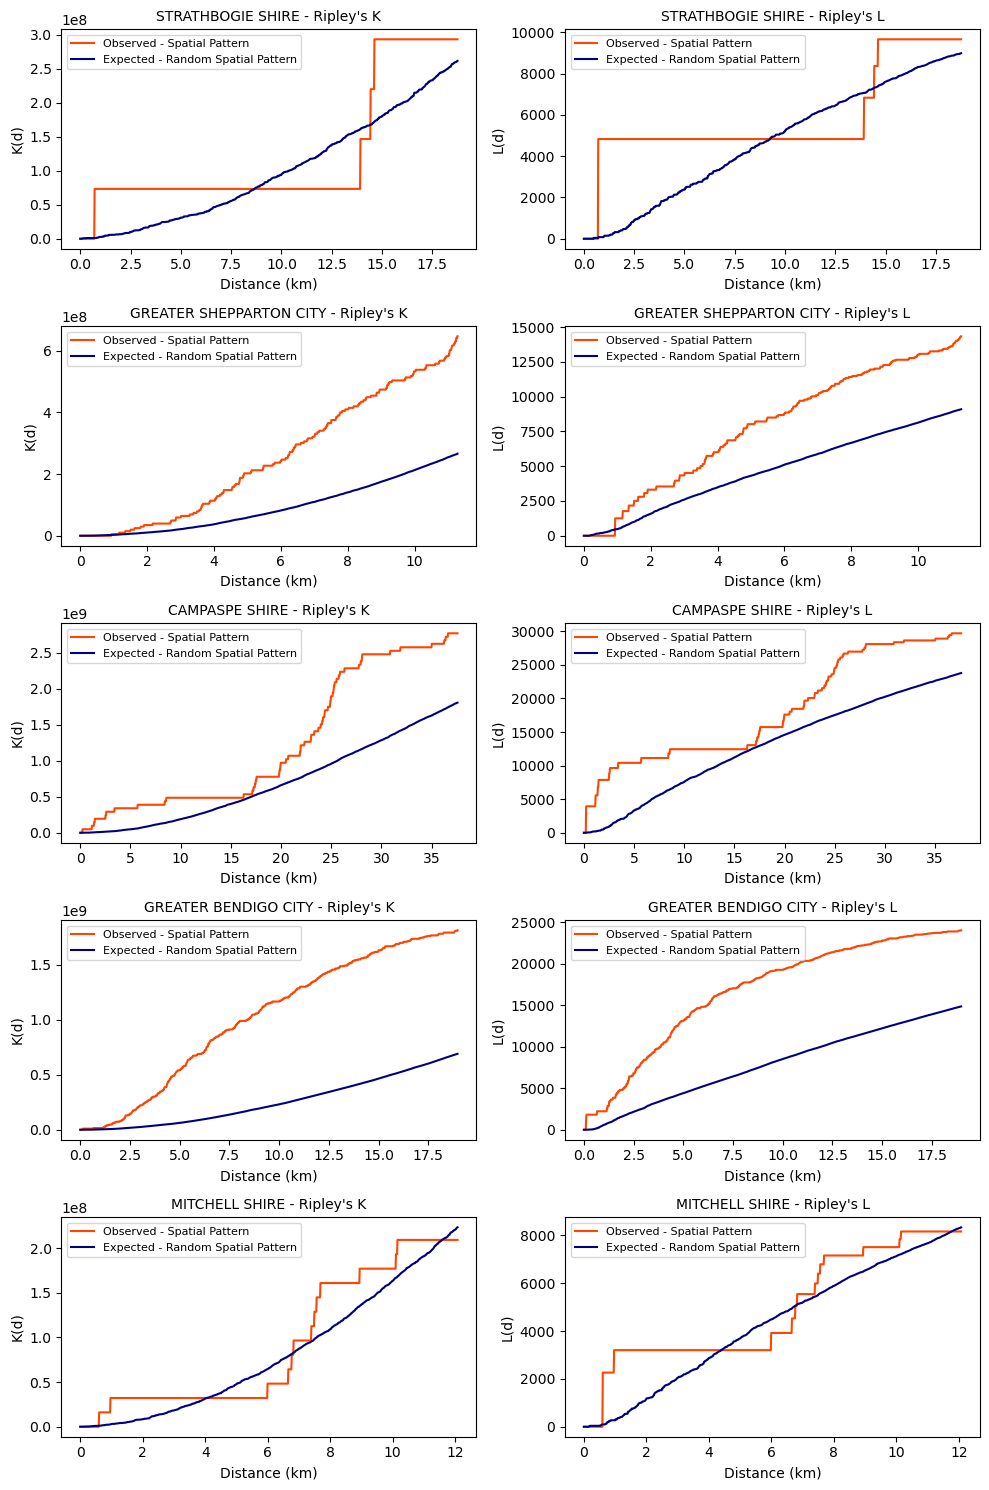

In [35]:
selectedLGAs = list(lgaGDF.set_index("LGA Name").geometry.items())

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10, 15))
axes = axes.reshape(5, 2)

for i, (lgaName, lgaPoly) in enumerate(selectedLGAs):
    schoolsInLGA = slLGA[slLGA.within(lgaPoly)]
    coords = np.array([(g.x, g.y) for g in schoolsInLGA.geometry])
    kRes = k_test(coords, support=1000, keep_simulations=True, n_simulations=99)
    lRes = l_test(coords, support=1000, keep_simulations=True, n_simulations=99)

    axK = axes[i, 0]
    axK.plot(kRes.support / 1000, kRes.statistic, 'orangered', label='Observed - Spatial Pattern')
    axK.plot(kRes.support / 1000, kRes.simulations.mean(0), 'navy', label='Expected - Random Spatial Pattern')
    axK.set_title(f"{lgaName} - Ripley's K", fontsize=10)
    axK.set_xlabel("Distance (km)")
    axK.set_ylabel("K(d)")
    axK.legend(fontsize=8)

    axL = axes[i, 1]
    axL.plot(lRes.support / 1000, lRes.statistic, 'orangered', label="Observed - Spatial Pattern")
    axL.plot(lRes.support / 1000, lRes.simulations.mean(0), 'navy', label="Expected - Random Spatial Pattern")
    axL.set_title(f"{lgaName} - Ripley's L", fontsize=10)
    axL.set_xlabel("Distance (km)")
    axL.set_ylabel("L(d)")
    axL.legend(fontsize=8)

plt.tight_layout()
plt.show()


- **Strathbogie Shire**: Schools are randomly spread out within local areas but grouped significantly at larger distances, likely indicating separate clusters of rural schools, but clusters significantly at distances greater than 14 km.
  
- **Greater Shepparton City and Greater Bendigo City**: Both areas have schools strongly clustered even at small distances (~2 km), suggesting concentrated urban areas with many schools close together.

- **Campaspe Shire**: Schools appear randomly placed at small scales but show clear clusters at distances over 15 km, reflecting multiple dispersed townships.

- **Mitchell Shire**: Schools have a mostly random distribution with slight clustering around moderate distances, probably indicating schools grouped around key towns.


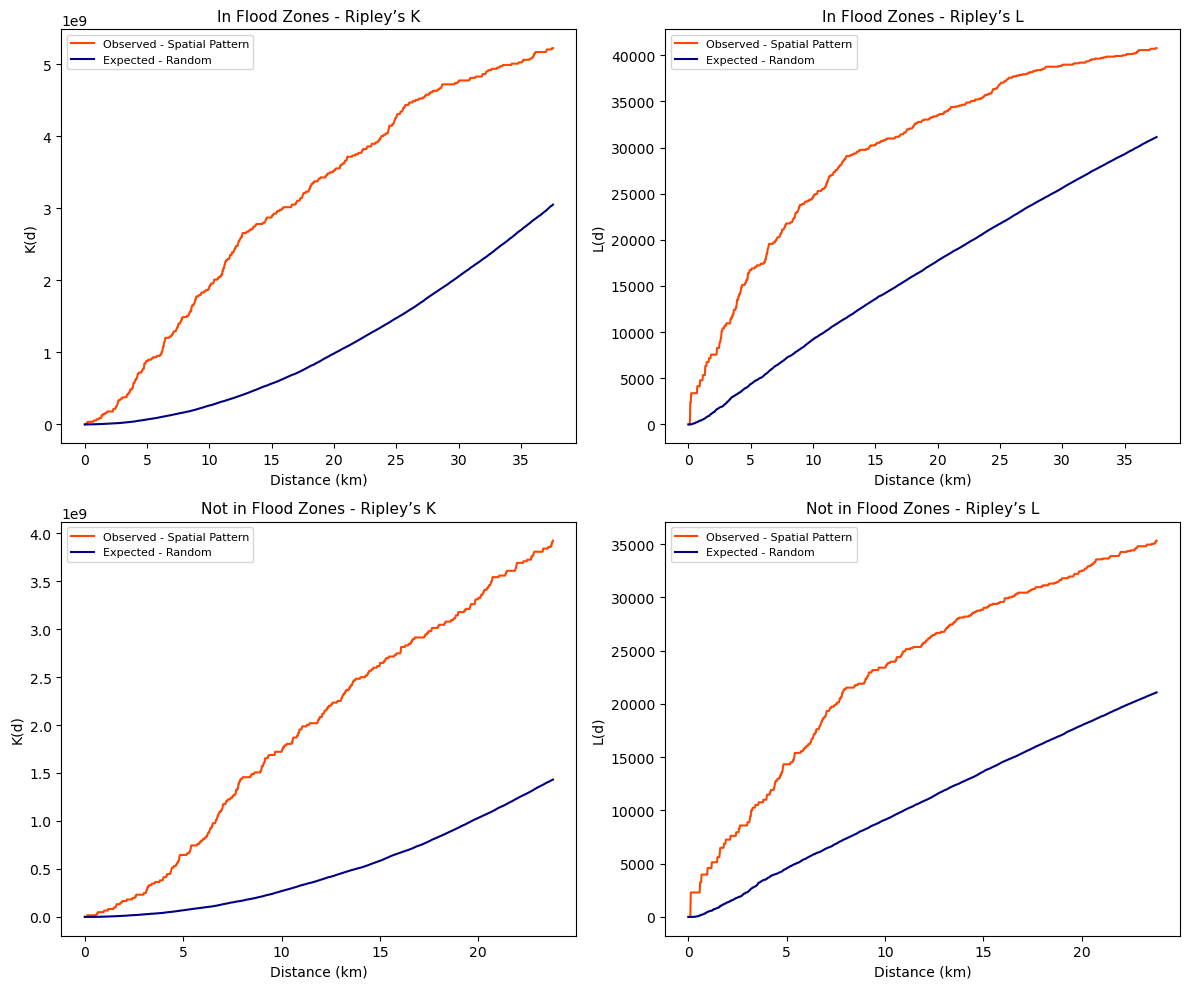

In [36]:
groups = {
    'In Flood Zones': slLGA[slLGA['inFlood'] == True],
    'Not in Flood Zones': slLGA[slLGA['inFlood'] == False]
}

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
axes = axes.reshape(2, 2)

for i, (label, gdf) in enumerate(groups.items()):
    coords = np.array([(pt.x, pt.y) for pt in gdf.geometry])

    kRes = k_test(coords, support=1000, keep_simulations=True, n_simulations=99)
    lRes = l_test(coords, support=1000, keep_simulations=True, n_simulations=99)

    # Ripley's K
    axK = axes[i, 0]
    axK.plot(kRes.support / 1000, kRes.statistic, 'orangered', label='Observed - Spatial Pattern')
    axK.plot(kRes.support / 1000, kRes.simulations.mean(0), 'navy', label='Expected - Random')
    axK.set_title(f"{label} - Ripley’s K", fontsize=11)
    axK.set_xlabel("Distance (km)")
    axK.set_ylabel("K(d)")
    axK.legend(fontsize=8)

    # Ripley's L
    axL = axes[i, 1]
    axL.plot(lRes.support / 1000, lRes.statistic, 'orangered', label='Observed - Spatial Pattern')
    axL.plot(lRes.support / 1000, lRes.simulations.mean(0), 'navy', label='Expected - Random')
    axL.set_title(f"{label} - Ripley’s L", fontsize=11)
    axL.set_xlabel("Distance (km)")
    axL.set_ylabel("L(d)")
    axL.legend(fontsize=8)

plt.tight_layout()
plt.show()

- **Schools in Flood Zones**: Both Ripley’s K and L functions show a strong upward deviation from the expected random pattern across all distances — particularly from 0 to 20 km — suggesting significant clustering of schools within flood-prone areas. This may reflect densely built towns or localities in floodplains where multiple schools are situated close together.

- **Schools Not in Flood Zones**: Clustering is still apparent but relatively weaker than in flood zones. While observed K and L values exceed expected values, the gap is narrower, indicating less intense clustering, potentially due to more dispersed rural schools in safer terrain.

Government schools located in flood zones exhibit **stronger and more sustained spatial clustering** than those in non-flooded areas. This pattern reinforces the idea that vulnerable clusters exist within flood-prone zones, warranting focused planning for flood mitigation and school accessibility.


##### <a id='toc3_2_1_1_3_'></a>[Ripley's G and F Function](#toc0_)

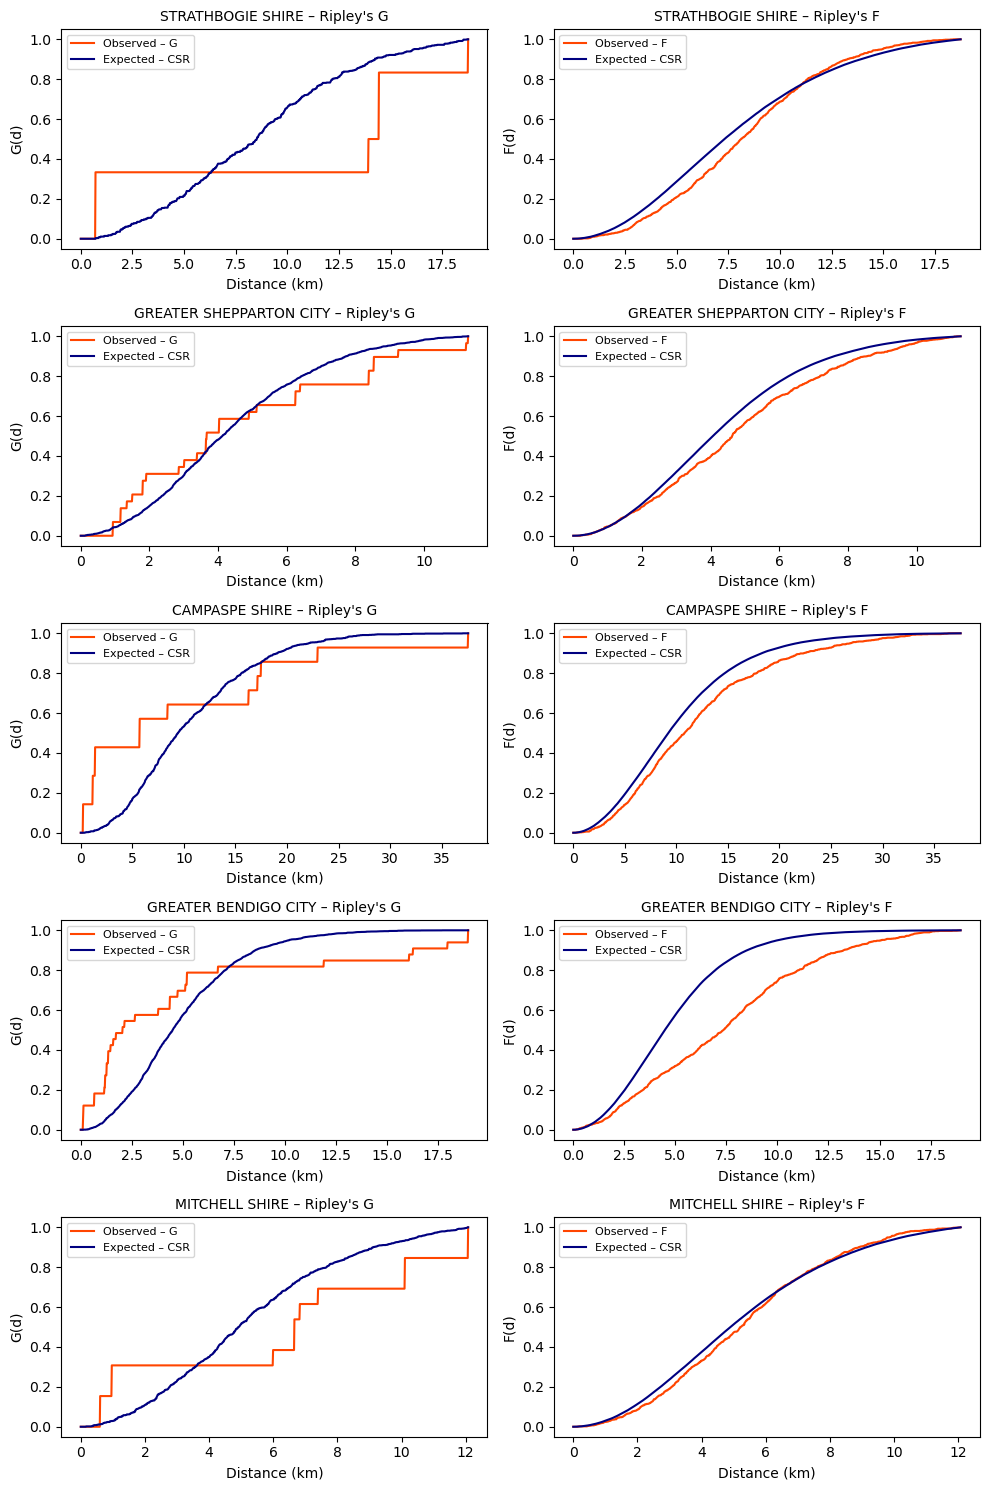

In [37]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10, 15))
axes = axes.reshape(5, 2)

for i, (lgaName, lgaPoly) in enumerate(selectedLGAs):
    schoolsInLGA = slLGA[slLGA.within(lgaPoly)]
    coords = np.array([(pt.x, pt.y) for pt in schoolsInLGA.geometry])

    gRes = g_test(coords, support=1000, keep_simulations=True, n_simulations=99)
    fRes = f_test(coords, support=1000, keep_simulations=True, n_simulations=99)

    axG = axes[i, 0]
    axG.plot(gRes.support / 1000, gRes.statistic,  'orangered', label='Observed – G')
    axG.plot(gRes.support / 1000, gRes.simulations.mean(0), 'navy', label='Expected – CSR')
    axG.set_title(f"{lgaName} – Ripley's G", fontsize=10)
    axG.set_xlabel("Distance (km)")
    axG.set_ylabel("G(d)")
    axG.legend(fontsize=8)

    axF = axes[i, 1]
    axF.plot(fRes.support / 1000, fRes.statistic,  'orangered', label='Observed – F')
    axF.plot(fRes.support / 1000, fRes.simulations.mean(0), 'navy', label='Expected – CSR')
    axF.set_title(f"{lgaName} – Ripley's F", fontsize=10)
    axF.set_xlabel("Distance (km)")
    axF.set_ylabel("F(d)")
    axF.legend(fontsize=8)

plt.tight_layout()
plt.show()

- **Strathbogie Shire**: Both methods show schools randomly spread locally, clustering beyond ~15 km.
- **Greater Shepparton & Greater Bendigo**: Both analyses confirm schools are clustered strongly even at small scales (~2 km), indicating dense urban distribution.
- **Campaspe Shire**: K/L and G/F both highlight randomness at short distances but clustering at distances beyond ~15 km, reflecting dispersed towns.
- **Mitchell Shire**: Both methods suggest randomness at small distances, with slight clustering at intermediate distances (~6–8 km), likely near key towns.

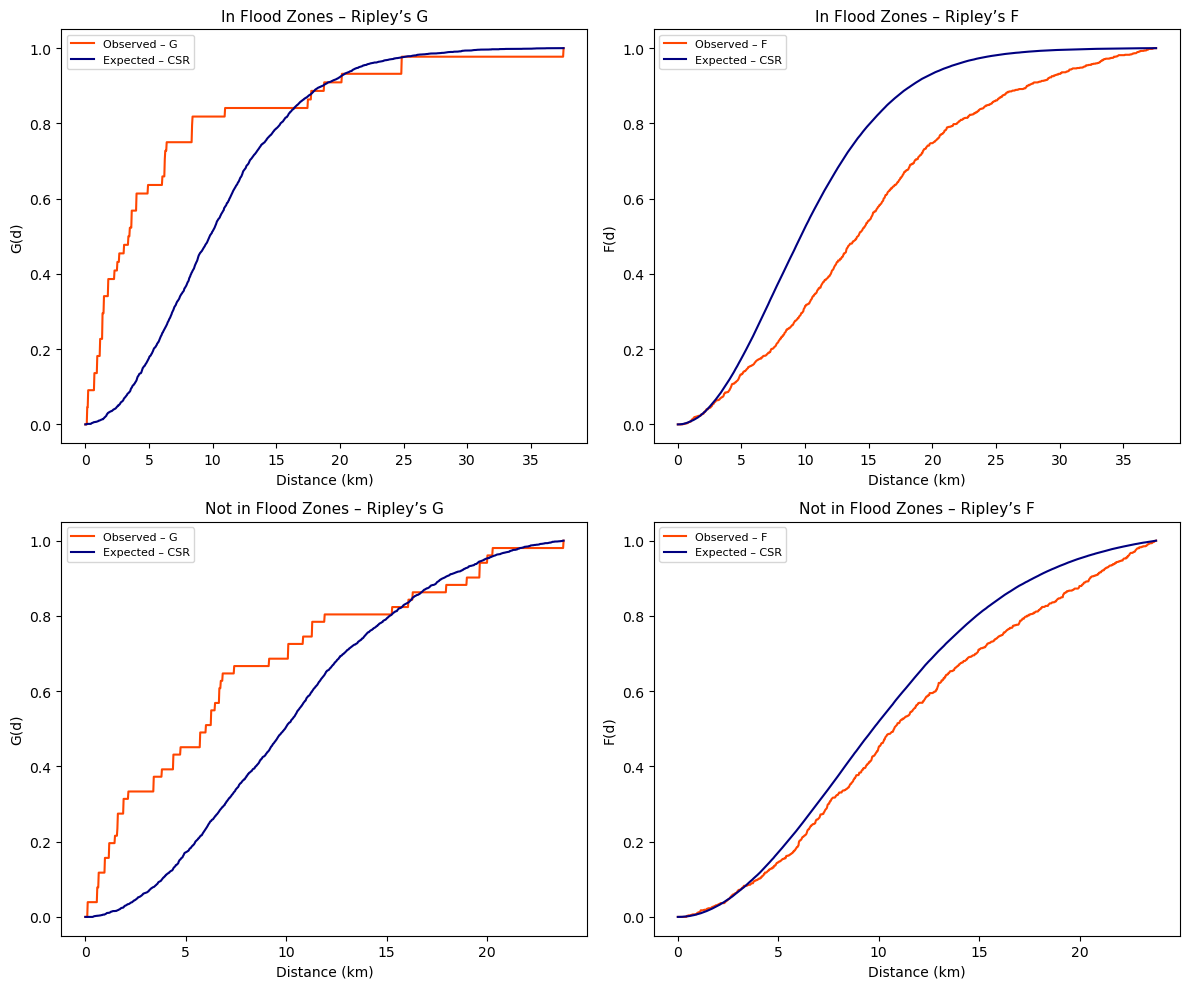

In [38]:
groups = {
    'In Flood Zones': slLGA[slLGA['inFlood'] == True],
    'Not in Flood Zones': slLGA[slLGA['inFlood'] == False]
}

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
axes = axes.reshape(2, 2)

for i, (label, gdf) in enumerate(groups.items()):
    coords = np.array([(pt.x, pt.y) for pt in gdf.geometry])
    
    if len(coords) < 5:
        continue  # Skip groups with too few points

    gRes = g_test(coords, support=1000, keep_simulations=True, n_simulations=99)
    fRes = f_test(coords, support=1000, keep_simulations=True, n_simulations=99)

    # G plot
    axG = axes[i, 0]
    axG.plot(gRes.support / 1000, gRes.statistic, 'orangered', label='Observed – G')
    axG.plot(gRes.support / 1000, gRes.simulations.mean(0), 'navy', label='Expected – CSR')
    axG.set_title(f"{label} – Ripley’s G", fontsize=11)
    axG.set_xlabel("Distance (km)")
    axG.set_ylabel("G(d)")
    axG.legend(fontsize=8)

    # F plot
    axF = axes[i, 1]
    axF.plot(fRes.support / 1000, fRes.statistic, 'orangered', label='Observed – F')
    axF.plot(fRes.support / 1000, fRes.simulations.mean(0), 'navy', label='Expected – CSR')
    axF.set_title(f"{label} – Ripley’s F", fontsize=11)
    axF.set_xlabel("Distance (km)")
    axF.set_ylabel("F(d)")
    axF.legend(fontsize=8)

plt.tight_layout()
plt.show()

- **Schools in Flood Zones**: The G function shows a sharp rise at small distances, indicating that schools are closely spaced and clustered at fine scales (within ~5 km). The F function lies well below the CSR expectation, suggesting large gaps between some school clusters — consistent with dense pockets of schools separated by broader flood-prone terrain.

- **Schools Not in Flood Zones**: The G curve still lies above CSR, but the rise is more gradual, indicating weaker clustering. The F curve remains close to the expected pattern, implying a more uniform distribution with fewer large gaps across the region.

Both G and F functions confirm that **government schools in flood zones are more spatially clustered**, while schools outside flood zones tend to be more evenly distributed. This reinforces concerns that flood-prone areas may host concentrated clusters of schools, increasing localized vulnerability during extreme events.


#### <a id='toc3_2_1_2_'></a>[Density-based methods](#toc0_)

##### <a id='toc3_2_1_2_1_'></a>[Quadrat Count](#toc0_)

In [39]:
rows = []

for lgaName, lgaPoly in lgaGDF.set_index('LGA Name').geometry.items():
    schoolsInLGA = slLGA[slLGA.within(lgaPoly)]
    coords = np.array([(g.x, g.y) for g in schoolsInLGA.geometry])

    pp = PointPattern(coords)
    qs = QStatistic(pp, shape='rectangle', nx = 4, ny = 4)

    counts = np.array(list(qs.mr.point_location_sta().values()))

    mean = np.mean(counts)
    var = np.var(counts, ddof = 1)
    vmr = var / mean
    chi2 = qs.chi2
    df = qs.df
    pVal = qs.chi2_pvalue
    
    pattern = 'clustered' if vmr > 1.1 else ('uniform' if vmr < 0.9 else 'random')
    rows.append({
        'LGA Name': lgaName,
        'Cells': len(counts),
        'Points': pp.n,
        'VMR': round(vmr, 2),
        'Chi-square': round(chi2, 2),
        'p-value': round(pVal, 3),
        'Pattern': pattern
    })

quadLGA = pd.DataFrame(rows).sort_values('LGA Name')
display(quadLGA)

LGA Name  Cells  Points   VMR  Chi-square  p-value  \
2           CAMPASPE SHIRE     16      14  1.20       18.00    0.263   
3     GREATER BENDIGO CITY     16      33  4.94       74.15    0.000   
1  GREATER SHEPPARTON CITY     16      29  2.66       39.97    0.000   
4           MITCHELL SHIRE     16      13  1.35       20.23    0.163   
0        STRATHBOGIE SHIRE     16       6  1.02       15.33    0.428   

     Pattern  
2  clustered  
3  clustered  
1  clustered  
4  clustered  
0     random

- **Greater Bendigo City** – VMR = 4.94, χ² = 74.15, p < 0.001 → schools are **strongly clustered** and the pattern is statistically significant.  

- **Greater Shepparton City** – VMR = 2.66, χ² = 39.97, p < 0.001 → **significant clustering** is also present, though less intense than Bendigo.  

- **Campaspe Shire** – VMR = 1.20, χ² = 18.00, p = 0.263 → only mild clustering; **not significant** at the 5 % level.  

- **Mitchell Shire** – VMR = 1.35, χ² = 20.23, p = 0.163 → moderate clustering but **still not significant**, counts could arise from randomness.  

- **Strathbogie Shire** – VMR = 1.02, χ² = 15.33, p = 0.428 → VMR is ~1 and the test is non-significant, so the distribution is **effectively random**.  

Only Greater Bendigo and Greater Shepparton show statistically significant school clustering; the other LGAs do not deviate from complete spatial randomness at the 5 % threshold.


In [40]:
groups = {
    'In Flood': slLGA[slLGA['inFlood'] == True],
    'Not in Flood': slLGA[slLGA['inFlood'] == False]
}

rows = []

for label, gdf in groups.items():
    coords = np.array([(pt.x, pt.y) for pt in gdf.geometry])
    if len(coords) < 5:
        continue  # too few points for quadrat count

    pp = PointPattern(coords)
    qs = QStatistic(pp, shape='rectangle', nx=4, ny=4)  # 4x4 grid

    counts = np.array(list(qs.mr.point_location_sta().values()))
    mean = np.mean(counts)
    var = np.var(counts, ddof=1)
    vmr = var / mean
    chi2 = qs.chi2
    df = qs.df
    pVal = qs.chi2_pvalue

    pattern = 'clustered' if vmr > 1.1 else ('uniform' if vmr < 0.9 else 'random')

    rows.append({
        'Group': label,
        'Cells': len(counts),
        'Points': pp.n,
        'VMR': round(vmr, 2),
        'Chi-square': round(chi2, 2),
        'p-value': round(pVal, 3),
        'Pattern': pattern
    })

quadFlood = pd.DataFrame(rows)
display(quadFlood)

Group  Cells  Points   VMR  Chi-square  p-value    Pattern
0      In Flood     16      44  5.07       76.00      0.0  clustered
1  Not in Flood     16      51  7.66      114.96      0.0  clustered

- **In Flood Zones** – VMR = 5.07, χ² = 76.00, p < 0.001 → schools are **strongly clustered**, and this pattern is **statistically significant**, indicating aggregation within specific high-risk areas.

- **Not in Flood Zones** – VMR = 7.66, χ² = 114.96, p < 0.001 → an even higher degree of **significant clustering** is present among schools outside the flood zones, suggesting that spatial concentration is a broader phenomenon, not limited to flood-prone areas.

Both groups of schools exhibit **strong and statistically significant clustering**, though the pattern is even more pronounced outside flood zones. This may reflect broader spatial development dynamics across the region, with schools forming clusters regardless of flood risk.


##### <a id='toc3_2_1_2_2_'></a>[Kernel Density Estimation](#toc0_)

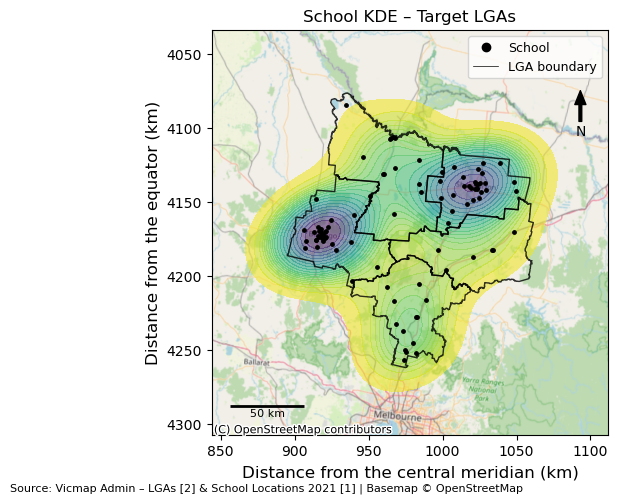

In [41]:
fig , ax = plt.subplots(figsize = (10 , 5))

sns.kdeplot(
    x = slLGA.geometry.x.values ,
    y = slLGA.geometry.y.values ,
    n_levels = 20 ,
    fill = True ,
    alpha = 0.55 ,
    cmap = 'viridis_r' ,
    ax = ax
)

ctx.add_basemap(ax , crs = slLGA.crs.to_string() , source = ctx.providers.OpenStreetMap.Mapnik)

slLGA.plot(ax = ax , color = 'k' , markersize = 6)
lgaGDF.boundary.plot(ax = ax , facecolor = 'none' , edgecolor = 'black' , linewidth = 1 , alpha = 0.8)

ax.set_title('School KDE – Target LGAs' , fontsize = 12)
ax.set_xlabel('Distance from the central meridian (km)' , fontsize = 12)
ax.set_ylabel('Distance from the equator (km)' , fontsize = 12)

ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x , _ : f'{x / 1000:.0f}'))
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y , _ : f'{abs(y) / 1000:.0f}'))

ax.annotate('N' , xy = (0.93 , 0.85) , xytext = (0.93 , 0.75) ,
            arrowprops = dict(facecolor = 'black' , width = 2 , headwidth = 8 , headlength = 10) ,
            ha = 'center' , va = 'center' , fontsize = 10 , xycoords = 'axes fraction')

sclX = ax.get_xlim()[0] + 12_500
sclY = ax.get_ylim()[0] + 20_000
ax.hlines(y = sclY , xmin = sclX , xmax = sclX + 50_000 , colors = 'black' , linewidth = 2)
ax.text(x = sclX + 25_000 , y = sclY - 7_500 , s = '50 km' , ha = 'center' , fontsize = 8)

handles = [
    Line2D([], [] , marker = 'o' , color = 'k' , linestyle = 'None' , markersize = 6 , label = 'School') ,
    Line2D([], [] , color = 'k' , linewidth = 0.5 , label = 'LGA boundary')
]
ax.legend(handles = handles , loc = 'upper right' , fontsize = 9)

fig.text(0.1 , 0.001 , 'Source: Vicmap Admin – LGAs [2] & School Locations 2021 [1] | Basemap © OpenStreetMap' ,
         fontsize = 8 , ha = 'left' , va = 'bottom')

plt.tight_layout()
plt.show()


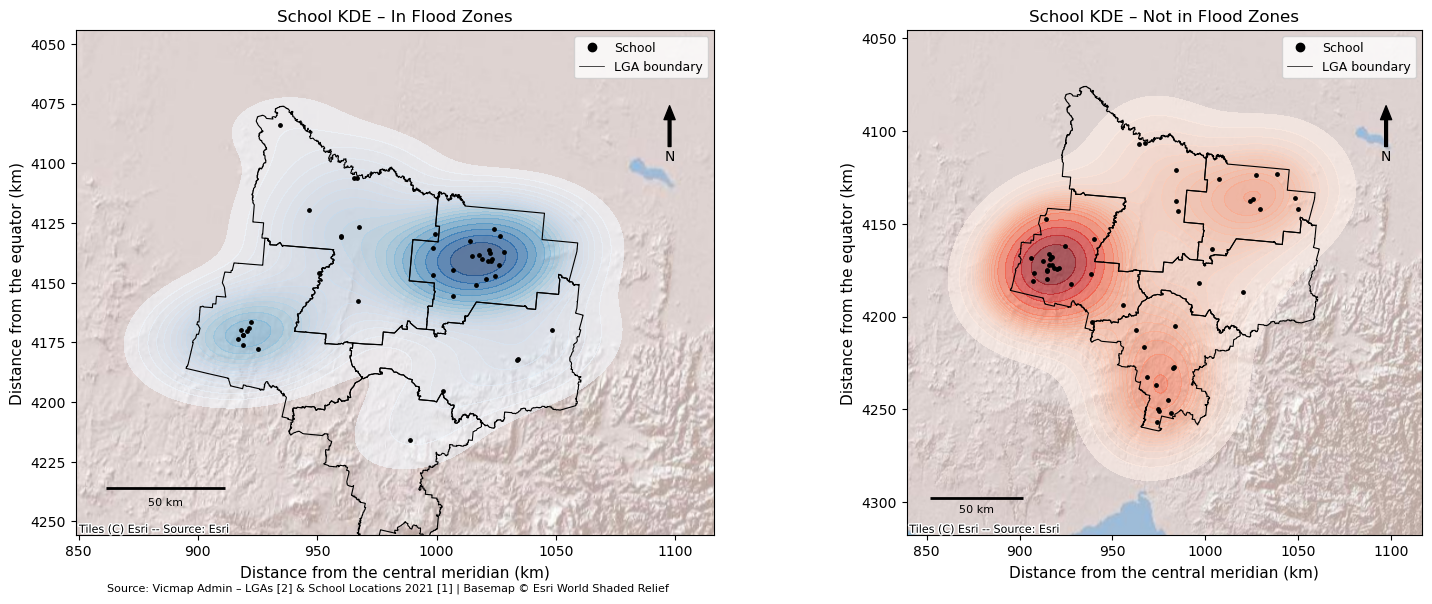

In [42]:
floodSchools = slLGA[slLGA['inFlood'] == True]
safeSchools  = slLGA[slLGA['inFlood'] == False]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

for ax, (label, gdf, cmap) in zip(axes, [
    ("In Flood Zones", floodSchools, 'Blues'),
    ("Not in Flood Zones", safeSchools, 'Reds')
]):
    # KDE surface
    sns.kdeplot(
        x=gdf.geometry.x,
        y=gdf.geometry.y,
        fill=True,
        cmap=cmap,
        alpha=0.6,
        n_levels=20,
        ax=ax
    )
    
    # Basemap + schools + LGA borders
    ctx.add_basemap(ax, crs='EPSG:7845', source=ctx.providers.Esri.WorldShadedRelief)
    gdf.plot(ax=ax, color='k', markersize=6)
    lgaGDF.boundary.plot(ax=ax, edgecolor='black', linewidth=0.8)

    # Title and labels
    ax.set_title(f"School KDE – {label}", fontsize=12)
    ax.set_xlabel("Distance from the central meridian (km)", fontsize=11)
    ax.set_ylabel("Distance from the equator (km)", fontsize=11)
    ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x / 1000:.0f}'))
    ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: f'{abs(y) / 1000:.0f}'))

    # North arrow
    ax.annotate('N', xy=(0.93, 0.85), xytext=(0.93, 0.75),
                arrowprops=dict(facecolor='black', width=2, headwidth=8, headlength=10),
                ha='center', va='center', fontsize=10, xycoords='axes fraction')

    # Scale bar
    sclX = ax.get_xlim()[0] + 12_500
    sclY = ax.get_ylim()[0] + 20_000
    ax.hlines(y=sclY, xmin=sclX, xmax=sclX + 50_000, colors='black', linewidth=2)
    ax.text(x=sclX + 25_000, y=sclY - 7_500, s='50 km', ha='center', fontsize=8)

    # Legend
    handles = [
        Line2D([], [], marker='o', color='k', linestyle='None', markersize=6, label='School'),
        Line2D([], [], color='black', linewidth=0.5, label='LGA boundary')
    ]
    ax.legend(handles=handles, loc='upper right', fontsize=9)

# Footer annotation
fig.text(0.1, 0.001, 'Source: Vicmap Admin – LGAs [2] & School Locations 2021 [1] | Basemap © Esri World Shaded Relief',
         fontsize=8, ha='left', va='bottom')

plt.tight_layout()
plt.show()

## <a id='toc3_3_'></a>[Areal Data Analysis](#toc0_)

In [43]:
schoolSA2 = (
    gpd.sjoin(
        slLGA.drop(columns=['LGA Name']),
        sa2LGA[['SA2 Code', 'LGA Name', 'geometry']],
        predicate='within',
        how='inner'
    )[['SA2 Code', 'LGA Name', 'inFlood']]
    .groupby(['SA2 Code', 'LGA Name'])['inFlood']
    .agg(total='count', flooded='sum')
    .reset_index()
)

schoolSA2['safe'] = 1 - (schoolSA2['flooded'] / schoolSA2['total'])

In [44]:
arealGDF = (seifaLGA.merge(schoolSA2, on=['SA2 Code', 'LGA Name']
                          , how='left')
           .merge(cenLGA[['SA2 Code', 'LGA Name', 'Primary Government Students','Secondary Government Students']]
                  , on=['SA2 Code', 'LGA Name']
                  , how='left'))

arealGDF['students'] = (arealGDF['Primary Government Students'] + arealGDF['Secondary Government Students'])


In [45]:
arealGDF = arealGDF[[
    'SA2 Code',
    'SA2 Name',
    'LGA Name',
    'Score',
    'total',
    'flooded',
    'safe',
    'students',
    'geometry'
]].copy()

arealGDF[['total', 'flooded', 'safe']] = arealGDF[['total', 'flooded', 'safe']].fillna(0)

arealGDF.head()

SA2 Code          SA2 Name           LGA Name  Score  total  flooded  \
0  204011054         Alexandra  STRATHBOGIE SHIRE    989    0.0      0.0   
1  204011057  Mansfield (Vic.)  STRATHBOGIE SHIRE   1028    0.0      0.0   
2  204011062               Yea  STRATHBOGIE SHIRE    995    0.0      0.0   
3  204011055             Euroa  STRATHBOGIE SHIRE    978    4.0      3.0   
4  204011058          Nagambie  STRATHBOGIE SHIRE    988    2.0      1.0   

   safe  students                                           geometry  
0  0.00       531  MULTIPOLYGON (((1026991.773 -4207812.382, 1026...  
1  0.00       904  MULTIPOLYGON (((1036457.832 -4202621.652, 1036...  
2  0.00       311  MULTIPOLYGON (((1018345.888 -4208373.157, 1018...  
3  0.25       433  POLYGON ((1013016.888 -4164093.610, 1013058.59...  
4  0.50       368  POLYGON ((977288.001 -4175151.548, 977323.762 ...

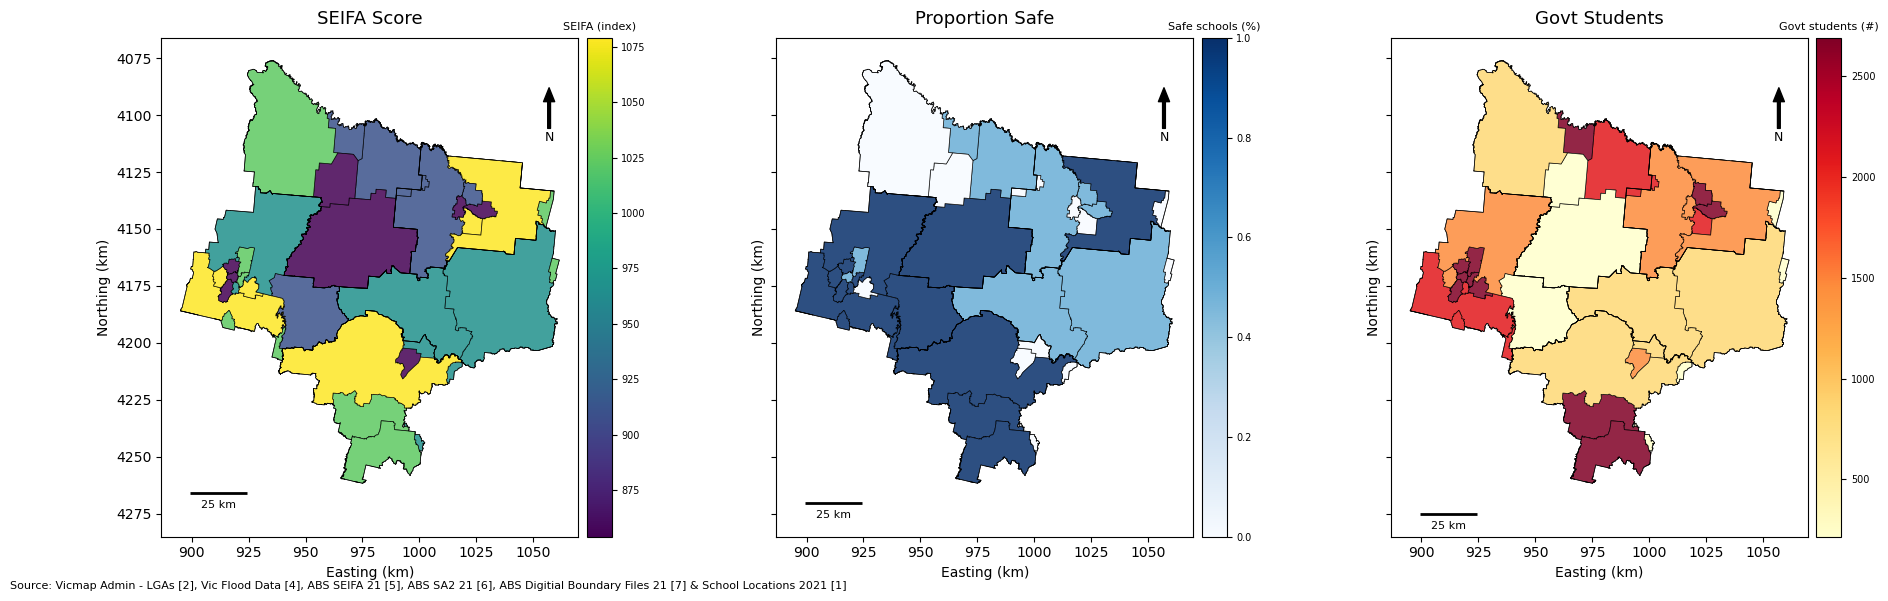

In [46]:
cols   = ['Score','safe','students']
titles = ['SEIFA Score','Proportion Safe','Govt Students']
cbLabs = ['SEIFA (index)','Safe schools (%)','Govt students (#)']
cmaps  = ['viridis','Blues','YlOrRd']

fig, axs = plt.subplots(1,3,figsize=(19,6),sharex=True,sharey=True)

for i,(v,ttl,cbarLab,cmap) in enumerate(zip(cols,titles,cbLabs,cmaps)):
    ax = axs[i]
    
    # choropleth
    arealGDF.plot(column=v, cmap=cmap, scheme='quantiles', k=5,
                  edgecolor='k', linewidth=0.5, alpha=0.85,
                  legend=False, ax=ax)
    lgaGDF.boundary.plot(ax=ax, edgecolor='black', linewidth=0.5, alpha=0.85)
    
    # orientation arrow
    ax.annotate('N', xy=(0.93,0.90), xytext=(0.93,0.80),
                arrowprops=dict(facecolor='black', width=2, headwidth=8, headlength=10),
                ha='center', va='center', fontsize=9, xycoords='axes fraction')
    
    # scale bar
    sx = ax.get_xlim()[0] + 12500
    sy = ax.get_ylim()[0] +  5000
    ax.hlines(y=sy, xmin=sx, xmax=sx+25000, colors='black', linewidth=2)
    ax.text(x=sx+12500, y=sy-6500, s='25 km', ha='center', fontsize=8)
    
    # axes & title
    ax.set_xlabel('Easting (km)', fontsize=10)
    ax.set_ylabel('Northing (km)', fontsize=10)
    ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x,_:f'{x/1000:.0f}'))
    ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y,_:f'{abs(y)/1000:.0f}'))
    ax.set_title(ttl, fontsize=13, pad=10)
    
    # colour-bar
    sm = plt.cm.ScalarMappable(cmap=cmap,
                               norm=plt.Normalize(vmin=arealGDF[v].min(),
                                                  vmax=arealGDF[v].max()))
    sm._A = []
    cbar = fig.colorbar(sm, ax=ax, fraction=0.045, pad=0.015)
    cbar.ax.set_title(cbarLab, fontsize=8, pad=6)
    cbar.ax.tick_params(labelsize=7)

fig.text(0.01,0.01,'Source: Vicmap Admin - LGAs [2], Vic Flood Data [4], ABS SEIFA 21 [5], ABS SA2 21 [6], ABS Digitial Boundary Files 21 [7] & School Locations 2021 [1]', fontsize=8, ha='left')
plt.tight_layout()
plt.show()


### <a id='toc3_3_1_'></a>[Global Autocorrelation](#toc0_)

#### <a id='toc3_3_1_1_'></a>[Moran’s 𝐼 Index, Geary’s 𝐶, General G-Statistic](#toc0_)

In [47]:
wSA2=libpysal.weights.Queen.from_dataframe(arealGDF)
wSA2.transform='r'

out=[]
for v in ['Score','safe','students']:
    x=arealGDF[v].fillna(0).values
    out.append({
        'var':v,
        'I':round(esda.Moran(x,wSA2).I,3),
        'pI':round(esda.Moran(x,wSA2).p_sim,4),
        'C':round(esda.Geary(x,wSA2).C,3),
        'pC':round(esda.Geary(x,wSA2).p_sim,4),
        'G':round(G(x,wSA2).G,3),
        'pG':round(G(x,wSA2).p_sim,4)
    })
pd.DataFrame(out)

var      I     pI      C     pC      G     pG
0     Score  0.147  0.029  0.805  0.019  0.090  0.274
1      safe  0.125  0.039  0.983  0.466  0.193  0.002
2  students  0.448  0.001  0.653  0.001  0.082  0.264

Global spatial autocorrelation

* **SEIFA Score** shows mild but significant clustering – Moran I = 0.147 (p = 0.021) and Geary C = 0.805 (p = 0.020) tell us similar socio-economic areas tend to sit next to each other.  
  
* **Proportion Safe** has a weak global Moran I = 0.125 (p = 0.033), yet General G = 0.193 (p = 0.005) flags clear hot-spots of high safety; the overall pattern is otherwise near-random (Geary C ≈ 1).  
  
* **Govt Students** is strongly clustered – Moran I = 0.448 and Geary C = 0.653 (both p < 0.01) – so SA2s with many students group together while low-student areas form their own cluster.  

What the choropleth maps confirm

1. Central SA2s are dark-purple on the SEIFA map (low index) – matching the positive clustering for disadvantage.  
   
2. Those same SA2s are light-blue/white in the safety map, proving that low-safety areas occur together.  
   
3. Peripheral SA2s appear yellow/green (high SEIFA) **and** dark-blue (high safety), underlining the hot-spot detected by General G. 
    
4. Deep-red student counts concentrate inside the low-SEIFA, low-safety belt, echoing the strong Moran I.  
   
5. Peripheral SA2s not only enjoy higher SEIFA and safety but also host fewer government students (pale yellow).  
   
6. Map and statistics together reveal a spatial inequity: the largest student populations face both socio-economic disadvantage and higher 
   flood exposure.  
7. Therefore, vulnerability is not random – it clusters in the same contiguous SA2 block.  
   
8. Policy attention should prioritise this central corridor where need, exposure, and student numbers intersect.  


### <a id='toc3_3_2_'></a>[Local Autocorrelation](#toc0_)

#### <a id='toc3_3_2_1_'></a>[Local Moran’s 𝐼 Index, Getis-Ord 𝐺𝑖 and 𝐺𝑖∗ statistics](#toc0_)

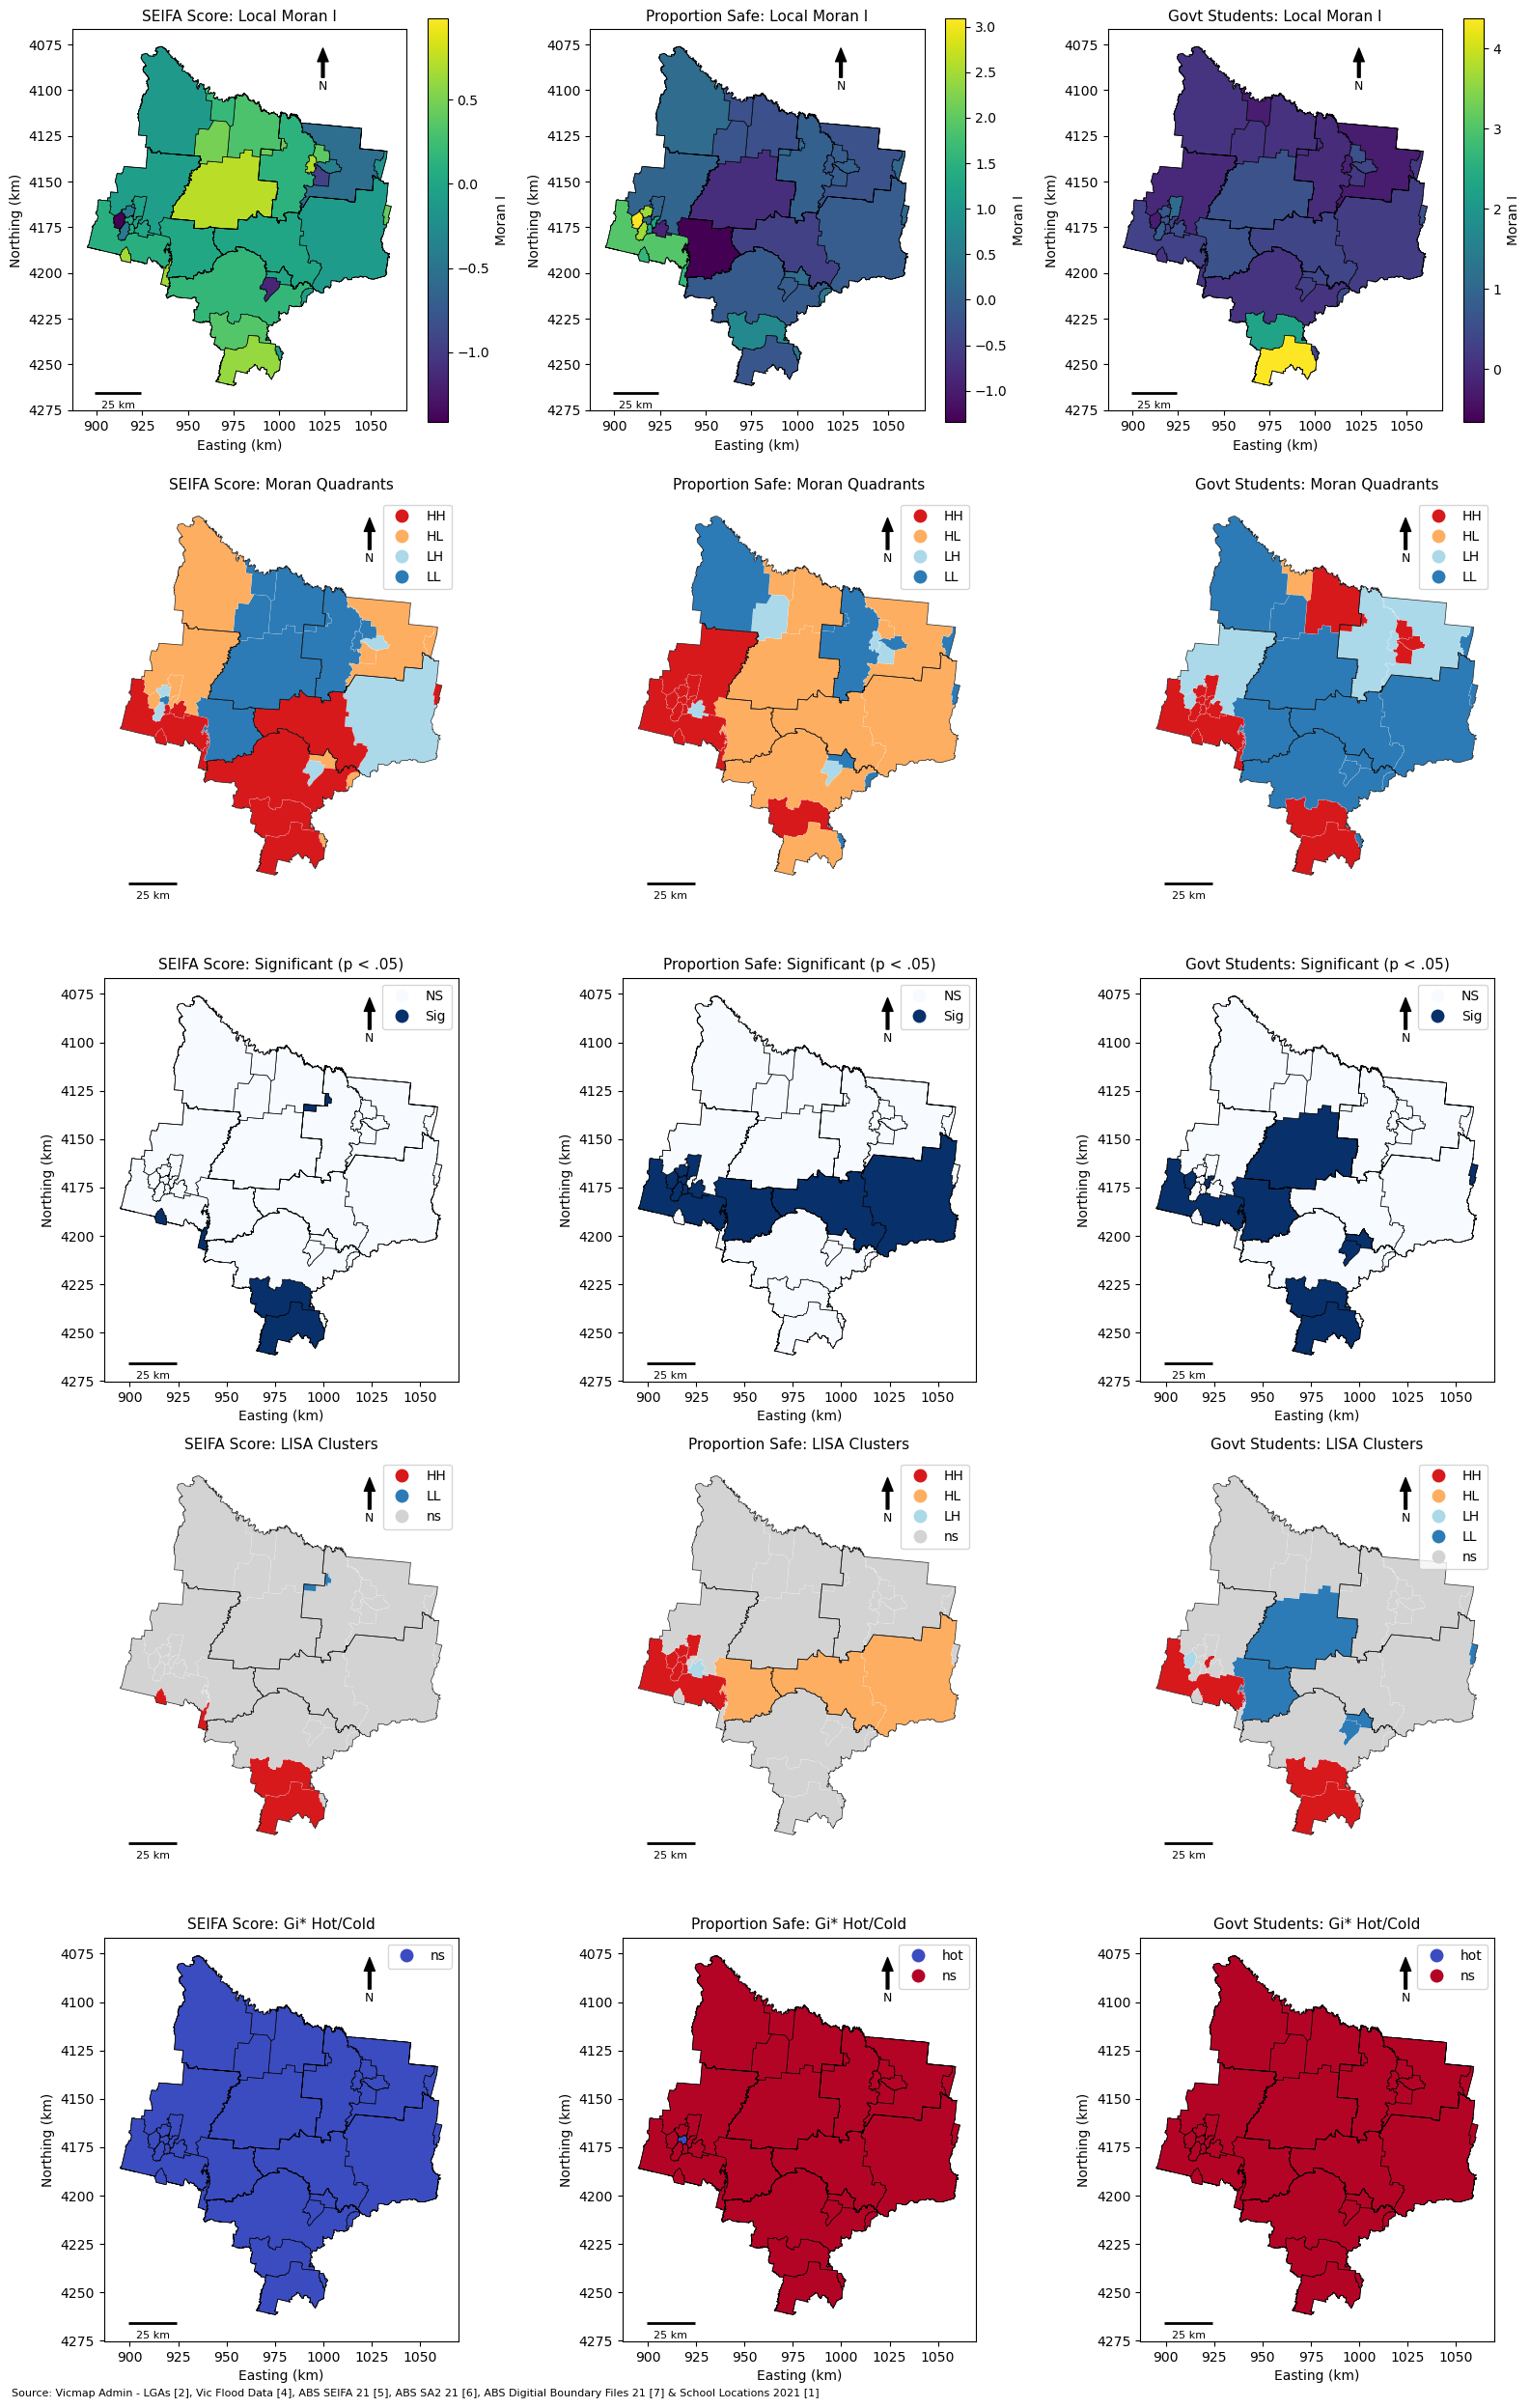

In [48]:
wSA2 = weights.KNN.from_dataframe(arealGDF, k=5)
wSA2.transform = "R" 

cols   = ['Score', 'safe', 'students']
titles = ['SEIFA Score', 'Proportion Safe', 'Govt Students']
cbLabs = ['Moran I','Moran I','Moran I']
cmaps  = ['viridis', 'Blues', 'YlOrRd']

fig, axs = plt.subplots(5, 3, figsize=(16, 25))

for j, (v, ttl, cmap, cbarLab) in enumerate(zip(cols, titles, cmaps, cbLabs)):
    
    x     = arealGDF[v].fillna(0).astype(float).values
    lisa  = Moran_Local(x, wSA2)
    gi    = G_Local(x, wSA2, permutations=0)

    arealGDF[f'{v}_I']    = lisa.Is
    arealGDF[f'{v}_sig']  = lisa.p_sim < .05
    arealGDF[f'{v}_quad'] = lisa.q
    arealGDF[f'{v}_gi']   = np.select(
                                [(gi.p_norm < .05) & (gi.Zs > 0),
                                 (gi.p_norm < .05) & (gi.Zs < 0)],
                                ['hot', 'cold'],
                                'ns'
                             )
    
    # Local Moran I values
    ax = axs[0, j]
    arealGDF.plot(column=f'{v}_I', cmap='viridis', k=5, edgecolor='k', linewidth=.5, ax=ax, legend=True, legend_kwds={'label': cbarLab})
    lgaGDF.boundary.plot(ax=ax, edgecolor='black', linewidth=0.5, alpha=.85)
    ax.set_title(f'{ttl}: Local Moran I', fontsize=11)

    
    # Quadrant map
    ax = axs[1, j]
    lisa_cluster(lisa, arealGDF, p=1, ax=ax)
    lgaGDF.boundary.plot(ax=ax, edgecolor='black', linewidth=0.5, alpha=.85)
    ax.set_title(f'{ttl}: Moran Quadrants', fontsize=11)
    
    # Significant vs NS
    ax = axs[2, j]
    arealGDF.assign(sig=arealGDF[f'{v}_sig'].map({True: 'Sig', False: 'NS'})) \
            .plot(column='sig', cmap='Blues', categorical=True, edgecolor='k', linewidth=.5, ax=ax, legend=True)
    lgaGDF.boundary.plot(ax=ax, edgecolor='black', linewidth=0.5, alpha=.85)
    ax.set_title(f'{ttl}: Significant (p < .05)', fontsize=11)

    # LISA clusters (p < .05)
    ax = axs[3, j]
    lisa_cluster(lisa, arealGDF, p=.05, ax=ax)
    lgaGDF.boundary.plot(ax=ax, edgecolor='black', linewidth=0.5, alpha=.85)
    ax.set_title(f'{ttl}: LISA Clusters', fontsize=11)
    
    # Gi* hot/cold spots
    ax = axs[4, j]
    arealGDF.plot(column=f'{v}_gi', categorical=True, cmap='coolwarm',
                  edgecolor='k', linewidth=0.5, ax=ax, legend=True)
    lgaGDF.boundary.plot(ax=ax, edgecolor='black', linewidth=0.5, alpha=.85)
    ax.set_title(f'{ttl}: Gi* Hot/Cold', fontsize=11)

for r in range(5):
    for c in range(3):
        ax = axs[r, c]

        ax.annotate('N', xy=(0.75, 0.95), xytext=(0.75, 0.85),
                    arrowprops=dict(facecolor='black', width=2,
                                    headwidth=8, headlength=10),
                    ha='center', va='center', fontsize=9,
                    xycoords='axes fraction')
        
        sx = ax.get_xlim()[0] + 12_500
        sy = ax.get_ylim()[0] + 5_000
        ax.hlines(y=sy, xmin=sx, xmax=sx + 25_000,
                  colors='black', linewidth=2)
        ax.text(sx + 12_500, sy - 6_500, '25 km',
                ha='center', va='center', fontsize=8)
        
        ax.set_xlabel('Easting (km)', fontsize=10)
        ax.set_ylabel('Northing (km)', fontsize=10)

        ax.xaxis.set_major_formatter(
            mtick.FuncFormatter(lambda x, _: f'{x/1000:.0f}')
        )
        ax.yaxis.set_major_formatter(
            mtick.FuncFormatter(lambda y, _: f'{abs(y)/1000:.0f}')
        )

fig.text(0.01,0.0005,'Source: Vicmap Admin - LGAs [2], Vic Flood Data [4], ABS SEIFA 21 [5], ABS SA2 21 [6], ABS Digitial Boundary Files 21 [7] & School Locations 2021 [1]', fontsize=8, ha='left')
plt.tight_layout()
plt.show()

The map displays the Local Moran’s I cluster patterns for government school flood exposure across Victorian SA2 regions. 

Key observations include:

- **High-High clusters** (dark red): Areas where high flood-exposure values are surrounded by similarly high values — notably visible in central northern regions, indicating localised vulnerability.
- **Low-Low clusters** (dark blue): Regions with low flood exposure surrounded by similar areas — generally in safer, elevated zones.
- **High-Low outliers** (light red): Anomalous regions with high flood exposure amidst low exposure surroundings — potentially isolated risk zones needing localized investigation.
- **Low-High outliers** (light blue): Safer regions embedded in risk-prone zones — candidates for best-practice resilience or protective location traits.

This spatial pattern confirms **significant spatial clustering** of school flood exposure, reinforcing the need for localized adaptation strategies.

## <a id='toc3_4_'></a>[Raster Analysis](#toc0_)

___

# <a id='toc4_'></a>[Geographically Weighted Regression](#toc0_)

# <a id='toc5_'></a>[Discussion and Sustainability](#toc0_)

___

# <a id='toc6_'></a>[Conclusion](#toc0_)

___

# <a id='toc7_'></a>[References](#toc0_)

[1] Department of Education and Training, *School Locations 2024 (Victoria)* [Data set], 2024. [Online]. Available: https://www.education.vic.gov.au/Documents/about/research/datavic/dv309_schoollocations2021.csv

[2] Department of Environment, Land, Water & Planning, *Vicmap Admin – Local Government Area (LGA) Polygon Aligned to Topographic Features* [Data set], May 30, 2025. [Online]. Available: https://datashare.maps.vic.gov.au/search?q=uuid%3Dbc822a9c-3766-57ac-a034-bcad3fb66d86

[3] Department of Transport and Planning, *Vicmap Elevation DEM 10m* [Data set], 2016. [Online]. Available: https://datashare.maps.vic.gov.au/search?q=uuid%3D2fd9d712-5407-51df-bc75-bb13d37499af

[4] Victorian Department of Environment and Primary Industries, *Victoria – 1 in 100 Year Flood Extent* [Data set], Mar. 30, 2016. [Online]. Available: https://data.gov.au/data/dataset/b02df5ce-3c17-4948-8869-776ad49a4b82

[5] Australian Bureau of Statistics, *Socio-Economic Indexes for Areas (SEIFA), Australia, 2021* [Data set], 2021. [Online]. Available: https://www.abs.gov.au/statistics/people/people-and-communities/socio-economic-indexes-areas-seifa-australia/latest-release

[6] Australian Bureau of Statistics, *2021 General Community Profile – Statistical Area Level 2 (SA2), Victoria* [Data set], 2021. [Online]. Available: https://www.abs.gov.au/census/find-census-data/datapacks

[7] Australian Bureau of Statistics, *Australian Statistical Geography Standard (ASGS): Edition 3 – Digital Boundary Files* [Data set], Jul. 2021 – Jun. 2026. [Online]. Available: https://www.abs.gov.au/statistics/standards/australian-statistical-geography-standard-asgs-edition-3/jul2021-jun2026/access-and-downloads/digital-boundary-files

___